In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd 
import sys
import pickle
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
from sklearn.metrics import pairwise_distances

workingdirectory = os.popen('git rev-parse --show-toplevel').read()[:-1]
sys.path.append(workingdirectory)
os.chdir(workingdirectory)

import allensdk.core.json_utilities as ju
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
from sklearn.kernel_ridge import KernelRidge

from mcmodels.core import Mask,ModelData,VoxelModelCache
from mcmodels.core.utils import get_structure_id, get_ordered_summary_structures,get_minorstructures,get_loss_paper
from mcmodels.utils import nonzero_unique, unionize
from mcmodels.core.experiment import get_voxeldata_msvd
from mcmodels.models.crossvalidation import get_best_hyperparameters,get_loss_best_hyp,get_loocv_predictions,get_loss
from mcmodels.core.utils import get_cre_status,get_minorstructure_dictionary,get_leaves_ontologicalorder
from mcmodels.core.utils import get_regionalized_normalized_data
from mcmodels.core.utils import get_connectivity
from mcmodels.core.utils import get_ontological_order_leaf
from mcmodels.core.utils import get_nw_loocv,get_wt_inds
from mcmodels.core.utils import get_countvec

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.linear_model.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
#read data
TOP_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
INPUT_JSON = os.path.join(TOP_DIR, 'input_011520.json')
EXPERIMENTS_EXCLUDE_JSON = os.path.join(TOP_DIR, 'experiments_exclude.json')
FILE_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
OUTPUT_DIR = os.path.join(FILE_DIR, 'output')

input_data = ju.read(INPUT_JSON)
manifest_file = input_data.get('manifest_file')
manifest_file = os.path.join(TOP_DIR, manifest_file)
experiments_exclude = ju.read(EXPERIMENTS_EXCLUDE_JSON)

#its unclear why the hyperparameters are loaded from the output directory
cache = VoxelModelCache(manifest_file=manifest_file)
major_structures = input_data.get('structures')
major_structure_ids = [get_structure_id(cache, s) for s in major_structures]
data_info = pd.read_excel('/Users/samsonkoelle/alleninstitute/Whole Brain Cre Image Series_curation only.xlsx', 'all datasets curated_070919pull')
data_info.set_index("id", inplace=True)
ontological_order = get_ordered_summary_structures(cache)

mcc = MouseConnectivityCache(manifest_file = '../connectivity/mouse_connectivity_manifest.json')
st = mcc.get_structure_tree()
ai_map = st.get_id_acronym_map()
ia_map = {value: key for key, value in ai_map.items()}

#regionalize voxel model: compare with regional model
#regional parameters
cre = None
eid_set=None
high_res=False
threshold_injection = False

COARSE_STRUCTURE_SET_ID = 2
DEFAULT_STRUCTURE_SET_IDS = tuple([COARSE_STRUCTURE_SET_ID])
tree = cache.get_structure_tree()
default_structures = tree.get_structures_by_set_id(DEFAULT_STRUCTURE_SET_IDS)
default_structure_ids = [st['id'] for st in default_structures if st['id'] != 934]
#cre= True

In [3]:
msvds = {}
#gammas = np.asarray([0.1])
for sid in major_structure_ids:
    print(sid)
    voxel_data = ModelData(cache, sid)
    print(cre)
    experiment_ids = voxel_data.get_experiment_ids(experiments_exclude=experiments_exclude, cre=cre)
    experiment_ids = np.asarray(list(experiment_ids))    
    msvd = get_voxeldata_msvd(cache, sid,experiments_exclude,default_structure_ids,cre)
    #msvd.l2losses, msvd.paperlosses,msvd.normspredict,msvd.normtrue = single_region_cv(msvd, gammas)
    msvds[sid]  = msvd

512
None
703
None
1089
None
1097
None
315
None
313
None
354
None
698
None
771
None
803
None
477
None
549
None


In [4]:
#get dictionaries of creline and leaf by experiment
creline = get_cre_status(data_info, msvds)
with open('data/info/leafs.pickle', 'rb') as handle:
    leafs = pickle.load(handle)
    
#get dictionary of minor structures for each experiment in each major division
#major division segregation is legacy code but convenient for fast cross validation in major division model
experiments_minor_structures = get_minorstructure_dictionary(msvds, data_info)

#get leaves in ontological order.  Where leafs don't exist, uses summary structure
ontological_order_leaves = get_leaves_ontologicalorder(msvd, ontological_order)

#Key isn't affected by which experiment we choose. This allows default masking to be inherited from the AllenSDK.
key = list(msvd.experiments.keys())[0]

#Identify keys denoting which voxels correspond to which structure in the ipsi and contra targets.
#contra_targetkey = msvd.experiments[list(msvd.experiments.keys())[0]].projection_mask.get_key(structure_ids=ontological_order_leaves, hemisphere_id=1)
#ipsi_targetkey = msvd.experiments[list(msvd.experiments.keys())[0]].projection_mask.get_key(structure_ids=ontological_order_leaves, hemisphere_id=2)
contra_targetkey = msvd.experiments[key].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=1)
ipsi_targetkey = msvd.experiments[key].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=2)

#get average intensities of projection structures given ipsi and contra keys
source_key = ontological_order #only relevant here when injection needs to be unionized, but currently a required argument
msvds = get_regionalized_normalized_data(msvds,cache, source_key,ipsi_targetkey,contra_targetkey)

#wt_2ormore = get_wt_inds(creline)

In [10]:
import math

# def get_cre_dist_cv(msvd, means_cast, eminors,cres):
#     nsamp = cres.shape[0]
#     credist = np.empty((nsamp,nsamp))
#     credist[:] = np.nan
#     for i in range(nsamp):
#         print(i)
#         #get mean of all points sharing cre line and minor structure with this one (but not including)
#         meani = means_cast.loc[tuple([eminors[i],cres[i]])]
#         ncr = len(np.where(cres == cres[i])[0])
#         meanloocvi = (ncr * meani ) / (ncr - 1) -   (1/ ncr)* msvd.reg_proj_vcount_norm_renorm[i] #results[reg[i]][tuple([cs[reg_cre_ind[j],1], cs[reg_cre_ind[k],1]])]
#         #rkeys = list(results[eminors[i]].keys())#np.asarray(list(results[experiments_minor_structures[sid][i]].keys()))
#         for j in range(nsamp):
#             meanj = means_cast.loc[cres[j]]
#             #t= tuple([cres[i], cres[j]])
#             if np.isin(t, rkeys).all():
#                 credist[i,j]  = np.linalg.norm(meanloocvi - meanj)
#     return(credist)
def get_cre_dist_cv(msvd, means_cast, eminors,cres):
    nsamp = cres.shape[0]
    credist = np.empty((nsamp,nsamp))
    credist[:] = np.nan
    for i in range(nsamp):
        print(i)
        #get mean of all points sharing cre line and minor structure with this one (but not including)
        meani = means_cast.loc[tuple([cres[i], eminors[i]])]
        ncr = len(np.where(cres == cres[i])[0])
        meanloocvi = meani
        meanloocvi = (ncr * meani ) / (ncr - 1) -   (1/ ncr)* msvd.reg_proj_vcount_norm_renorm[i] #results[reg[i]][tuple([cs[reg_cre_ind[j],1], cs[reg_cre_ind[k],1]])]
        #rkeys = list(results[eminors[i]].keys())#np.asarray(list(results[experiments_minor_structures[sid][i]].keys()))
        for j in range(nsamp):
            meanj = means_cast.loc[tuple([cres[j], eminors[j]])]
            #t= tuple([cres[i], cres[j]])
            #if np.isin(t, rkeys).all():
            if eminors[j] == eminors[i]:
                credist[i,j]  = np.linalg.norm(meanloocvi - meanj)

    return(credist)


def get_smoothed_losses(msvd, qqq, cre_dist):
    ds = pairwise_distances(msvd.centroids)**2
    cs = cre_dist
    ds2 = ds[np.where(~np.isnan(cs))]
    cs2 = cs[np.where(~np.isnan(cs))]
    dsnorm  = np.linalg.norm(ds2)
    csnorm = np.linalg.norm(cs2)
    
    ls = pairwise_distances(msvd.reg_proj_vcount_norm_renorm)**2
    nsamp = ds.shape[0]
    bbbb = np.asarray(np.where(~np.isnan(cs))).transpose()
    smoothedlosses = np.empty((nsamp,nsamp))
    smoothedlosses[:] = np.nan
    for i in range(bbbb.shape[0]):
        ci = cs[bbbb[i,0], bbbb[i,1]] / csnorm
        di = ds[bbbb[i,0], bbbb[i,1]] / dsnorm
        smoothedlosses[bbbb[i,0], bbbb[i,1]] = qqq.predict(np.asarray([[ci, di]]))
    return(smoothedlosses)

In [6]:
ipsi_target_regions, ipsi_target_counts = nonzero_unique(ipsi_targetkey, return_counts=True)
contra_target_regions, contra_target_counts = nonzero_unique(contra_targetkey, return_counts=True)
target_order = lambda x: np.array(ontological_order)[np.isin(ontological_order, x)]
permutation = lambda x: np.argsort(np.argsort(target_order(x)))
targ_ids = np.concatenate([ipsi_target_regions[permutation(ipsi_target_regions)],
                           contra_target_regions[permutation(contra_target_regions)]])
colnames = np.asarray([ia_map[targ_ids[i]] for i in range(len(targ_ids))])

In [11]:
from sklearn.metrics.pairwise import pairwise_kernels
from mcmodels.regressors.nonparametric.nadaraya_watson import get_weights

def get_best_hyperparameters(losses, keys):
    
    major_structure_ids = np.asarray(list(losses.keys()))
    nms = len(major_structure_ids)
    nkey = keys.shape[1]
    output = np.empty((nms, nkey))
    for m in range(nms):
        print(m)
        sid = major_structure_ids[m]
        lvec = np.asarray([np.nanmean(losses[sid][key]) for key in keys])
        if np.any(~np.isnan(lvec)):
            output[m] = keys[np.nanargmin(lvec)]
        # if len(np.where(np.isnan(np.nanmean(losses[sid][:,:], axis = 1)))[0]) < losses[sid].shape[0]:
        #    output[m] = np.nanargmin(np.nanmean(losses[sid][:,:], axis = 1))

    output = np.asarray(output, dtype=int)
    return(output)

#get where we actually modelled
def get_eval_indices(eval_index_matrices):
    eval_indices = {}
    major_structure_ids = np.asarray(list(eval_index_matrices.keys()))
    for sid in major_structure_ids:
        eval_indices[sid] = np.where(eval_index_matrices[sid].sum(axis = 0) > 0)[0]
    return(eval_indices)    



def get_weights(eval_centroids, model_centroids, gamma):
    weights = pairwise_kernels(X=eval_centroids, Y=model_centroids, metric='rbf', gamma=gamma, filter_params=True)
    return (weights)


def get_indices(ids):

    ids_unique = np.unique(ids)
    output = np.zeros((len(ids_unique), len(ids)), dtype = int)
    for i in range(len(ids_unique)):
        output[i,np.where(ids == ids_unique[i])[0] ] = 1
    return(output)

#get indices of firstlist in firstlisttest in categories defined by secondlist
def get_indices2(firstlist, firstlisttest, secondlist):
    
    sl_unique = np.unique(secondlist)
    output = np.zeros((len(sl_unique), len(secondlist)), dtype = int)
    for i in range(len(sl_unique)):
        output[i,np.intersect1d(np.where(np.isin(firstlist,firstlisttest))[0], np.where(secondlist == sl_unique[i])[0])] = 1
    return(output)

#nmodels = nleafs
#populate each with experiments that share summary structure
def get_indices_summaryinleaf(summarylist , leaflist):
    
    nexp = len(leaflist)
    leaf_unique = np.unique(leaflist)
    output = np.zeros((len(leaf_unique), nexp), dtype = int)
    
    for i in range(len(leaf_unique)):
        
        summary = summarylist[np.where(leaflist == leaf_unique[i])[0]][0]
        output[i,np.where(summarylist == summary)[0]] = 1
        
        
    return(output)

#get predictions at all eval_indices using model_indices
#if an eval_indices is also a model indice, leave it out of the model
#if a model index is not an eval index, it never gets left out
def get_nwloocv_predictions_singlemodel(projections, centroids, gamma, model_indices, eval_indices):
  
    eval_index_val = np.where(eval_indices == 1)[0]
    model_index_val = np.where(model_indices == 1)[0]
    
    projections = np.asarray(projections, dtype=np.float32)
    
    nmod_ind = len(model_index_val)
    neval = len(eval_index_val)
    #nexp = centroids.shape[0]
    predictions = np.empty(projections.shape)
    #print(model_index_val.shape, eval_index_val.shape)

    if len(model_index_val) > 0 and  len(eval_index_val) > 0:
        weights = pairwise_kernels(centroids[model_index_val], centroids[eval_index_val], metric='rbf', gamma=gamma, filter_params=True) #get_weights(centroids, gamma)
        for i in range(neval):
            matchindex = np.where(model_index_val == eval_index_val[i])[0]
            otherindices = np.setdiff1d(np.asarray(list(range(nmod_ind))), matchindex)         
            #this order of operations is the fastest I found
            weights_i = weights[:,i] / weights[:,i][otherindices].sum()
            weights_i[matchindex] = 0
            weights_i = np.asarray(weights_i, dtype=np.float32)
            pred = np.dot(weights_i, projections[model_index_val])
            predictions[eval_index_val[i]] = pred

        
    return(predictions)    

def get_nwloocv_predictions_multimodel(projections, centroids, gammas, model_index_matrix, eval_index_matrix):
    

    
    ntargets = projections.shape[1]
    nexp = projections.shape[0]
    nmodels = model_index_matrix.shape[0]
    ngammas = len(gammas)
    
    projections = np.asarray(projections, dtype=np.float32)
    predictions = np.empty((nmodels, ngammas, nexp, ntargets))
    
    
    for m in range(nmodels):
        #print('m', m, len(np.where(model_index_matrix[m] ==1)[0]))
        predictions[m] = np.asarray([get_nwloocv_predictions_singlemodel(projections, centroids, gammas[g], model_index_matrix[m], eval_index_matrix[m]) for g in range(ngammas)])
    
    return(predictions)  

def combine_predictions(predictions, eval_index_matrix):
    
    nmodels, ngammas, nexp, ntargets = predictions.shape
    combined_predictions = np.empty((ngammas, nexp, ntargets))
    for m in range(nmodels):
        combined_predictions[:,np.where(eval_index_matrix[m] == 1)[0]] = predictions[m][:,np.where(eval_index_matrix[m] == 1)[0]]
        
    return(combined_predictions)

def get_nwloocv_predictions_multimodel_merge(projections, centroids, gammas, model_index_matrix, eval_index_matrix):
    
    predictions_unmerged = get_nwloocv_predictions_multimodel(projections, centroids, gammas, model_index_matrix, eval_index_matrix)
    print(predictions_unmerged.shape)
    predictions_merged = combine_predictions(predictions_unmerged, eval_index_matrix)
    
    return(predictions_merged)

#we should not pass model_index_matrices that are identical to eval_index_matrices and have only 1 element per model
#although in principal we could do automatically in the cross validation code 
#we would rather do it explicitly to ensure identical indexing b/w experiments
#if we only have 1 model index we will remove the model index from eval indices
def screen_indices(model_indices, eval_indices):
    
    eval_indices2 = eval_indices.copy()
    mod_loc = np.where(model_indices == 1)[0]
    if len(mod_loc) == 1:
        eval_indices2[mod_loc] = 0
    return(eval_indices2)

#this could result in an empty eval index i.e. certain indices having no prediction.  catch later
#can merge (sum) the index matrix to see where predictions are actually generated
def screen_index_matrices(model_index_matrices, eval_index_matrices):
    
    #alter eval_indices to remove model index in cases where there is only one experiment in the model
    
    nmodels = model_index_matrices.shape[0]
    eval_index_matrices2 = eval_index_matrices.copy()
    for m in range(nmodels):
        eval_index_matrices2[m] = screen_indices(model_index_matrices[m], eval_index_matrices[m])
    
    return(eval_index_matrices2)

#need code for removing experiments that have no model
#this can happen when the model set is a subset of the evaluation set.
#we will therefore generate predictions for a subset
#given a leaf is included, the eval set is the same
#however, we want to remove evals in leaves we don't have a wt for... of course one could say we are doing worse...
#but we also have a fewer number of models
#model_index_matrices are the indices of the leafs'
#indices_wtinleaf are the wild types
#need to make sure we dont have leafs with only 1 experiment


def screen_index_matrices2(model_index_matrices, eval_index_matrices):
    
    #alter model and eval matrices to be nonzero only when there are at least two experiments in the model
    #it can be useful for when model_index_matrices is a subset of eval_index_matrices
    #nmodels = model_index_matrices.shape[0]
    include_per_model = model_index_matrices.sum(axis= 1)
    to_exclude = np.where(include_per_model <= 1)[0]
    #to_include = np.where(include_per_model > 0)[0]
    
    model_index_matrices2 = model_index_matrices.copy()
    eval_index_matrices2 = eval_index_matrices.copy()
    model_index_matrices2[to_exclude] = 0
    eval_index_matrices2[to_exclude] = 0
    
    return(model_index_matrices2, eval_index_matrices2)

def screen_index_matrices3(model_index_matrices, eval_index_matrices):
    
    #alter model and eval matrices to be nonzero only when there are at least one experiments in the model
    #it can be useful for when model_index_matrices is a subset of eval_index_matrices
    #nmodels = model_index_matrices.shape[0]
    include_per_model = model_index_matrices.sum(axis= 1)
    to_exclude = np.where(include_per_model < 1)[0]
    #to_include = np.where(include_per_model > 0)[0]
    
    model_index_matrices2 = model_index_matrices.copy()
    eval_index_matrices2 = eval_index_matrices.copy()
    model_index_matrices2[to_exclude] = 0
    eval_index_matrices2[to_exclude] = 0
    
    to_remove = np.where(include_per_model == 1)[0]
    eval_index_matrices2[to_remove] = 0
    
    return(model_index_matrices2, eval_index_matrices2)

def get_cre_similarity(msvd, cres,eminors,colnames):

    ss = np.append(['cre','injsum'],colnames)
    ns = np.concatenate([np.empty(2, dtype = str), np.repeat('ipsi',291), np.repeat('contra',286)])
    colns = np.vstack([ns,ss]).transpose()
    clns = list(zip(*colns.transpose()))
    clnsmi = pd.MultiIndex.from_tuples(clns, names=['first', 'second'])
    data_merged = pd.DataFrame(np.hstack([np.expand_dims(cres,1),np.expand_dims(eminors,1),msvd.reg_proj_vcount_norm_renorm ]), columns= clnsmi)
    data_melted = pd.melt(data_merged, id_vars=[('','cre'),('','injsum')])
    data_melted = data_melted.astype({'value': np.float64})
    means = data_melted.groupby(by=['first', 'second',('','cre'),('','injsum')])['value'].mean().reset_index()
    means = means.astype({'value': np.float64})
    means_cast = pd.pivot_table(means, index = [('','cre'),('','injsum')], columns = ['first', 'second'])
    cs = np.asarray(list(means_cast.index))    
    return(means_cast,cs)

In [8]:
from mcmodels.regressors import NadarayaWatson

In [9]:
a = NadarayaWatson()

In [ ]:
a.fit()

In [12]:
indices_leaf = {}
indices_wtinleaf = {}
indices_wtleaf = {}
indices_summary = {}
indices_summaryinleaf = {}
indices_major = {}
indices_majorinleaf = {}
indices_leaf2ormore = {}
indices_wtinleaf2ormore = {}
indices_leaf_reduced = {}
indices_wtinleaf_reduced = {}
indices_wt_leaf2ormore = {}
indices_leaf2ormore_wt = {}
indices_wt1ormore_leaf2ormore = {}
indices_leaf2ormore_wt1ormore = {}
for sid in major_structure_ids:
    
    #wt_leaf on leaf

    #get the indices of experiments sharing leafs (nmodels is number of leafs)
    indices_leaf[sid] = get_indices(leafs[sid]) #eval_indices
    #indices_creleaf = get_indices(leafs[sid])
    
    #get the indices of the wts in the leaf (nmodels is number of leafs)
    indices_wtinleaf[sid] = get_indices2(creline[sid], np.asarray(['C57BL/6J']),leafs[sid]) #model_indices
    
    #get indices of experiments sharing summary structure x cre combination (nmodel is number of cre x leaf combinations)
    #indices_wtleaf[sid] = get_indices(creleafs_merged[sid])
    
    #get indices of experiments sharing summary structure(nmodel is number of summary structures)
    indices_summary[sid] = get_indices(experiments_minor_structures[sid])
    
    #get indices of experiments sharing major structure(nmodel is number of summary structures)
    indices_major[sid] = np.ones((1,experiments_minor_structures[sid].shape[0]))
    
    #get indices of experiments sharing same major structure as a leaf (nmodel is number of leafs)
    indices_majorinleaf[sid] = np.ones((len(np.unique(leafs[sid])),experiments_minor_structures[sid].shape[0]))#get_indices2(np.ones(len(leafs[sid])), np.asarray([1]),leafs[sid]) #model_indices
    
    #get indices of experiments in same summary structure as a leaf (nmodel is number of leafs)
    indices_summaryinleaf[sid] = get_indices_summaryinleaf(experiments_minor_structures[sid], leafs[sid])
    
    #evaluate models on leafs
    indices_leaf2ormore[sid] = screen_index_matrices(indices_leaf[sid], indices_leaf[sid])
    
    indices_wt1ormore_leaf2ormore[sid], indices_leaf2ormore_wt1ormore[sid] = screen_index_matrices3(indices_wtinleaf[sid], indices_leaf2ormore[sid])
    
    indices_wtinleaf2ormore[sid] = screen_index_matrices(indices_wtinleaf[sid], indices_wtinleaf[sid])
    indices_leaf_reduced[sid], indices_wtinleaf_reduced[sid]  = screen_index_matrices2( indices_leaf2ormore[sid],indices_wtinleaf[sid])


In [46]:
def get_loss_surface_NW(msvd,cre_dist, fraction):
    #ds = pairwise_distances(msvd.centroids)**2
    cs = cre_dist
    #ls = pairwise_distances(msvd.reg_proj_vcount_norm_renorm)**2
    nsamp = msvd.centroids.shape[0]
    #need source and target color
    source = np.repeat(np.linspace(0,nsamp - 1, nsamp, dtype = int), nsamp)
    target = np.tile(np.linspace(0,nsamp - 1, nsamp, dtype = int), nsamp)
    goodpairs = np.asarray(np.where(~np.isnan(cs))).transpose()
    ngp = goodpairs.shape[0]
    centroids = msvd.centroids
    projs = msvd.reg_proj_vcount_norm_renorm
    ds2 = np.zeros(ngp)
    ls2 = np.zeros(ngp)
    for i in range(ngp):
        print(i)
        ds2[i] = np.linalg.norm(centroids[goodpairs[i][0]] - centroids[goodpairs[i][1]])**2
        ls2[i] = np.linalg.norm(projs[goodpairs[i][0]] - projs[goodpairs[i][1]])**2
        
    cs2 = cs[np.where(~np.isnan(cs))]    
    #ds2 = ds[np.where(~np.isnan(cs))]
    #
    source2 = source[np.where(~np.isnan(cs.flatten()))]
    target2 = target[np.where(~np.isnan(cs.flatten()))]

    dsnorm  = np.linalg.norm(ds2)
    csnorm = np.linalg.norm(cs2)

    ds2 = ds2 / dsnorm
    cs2 = cs2 / csnorm
    #ls2 = ls[np.where(~np.isnan(cs))]

    dc = np.asarray([ds2,cs2,ls2]).transpose()
    #ids = np.linspace(0,35, 36, dtype = int), 36)
    
    qqq = NadarayaWatson(kernel='rbf',  gamma  = 100)
    randos = random.sample(list(range(ngp)), math.floor(ngp * fraction))
    qqq.fit(dc[:,:2][randos], dc[:,2:][randos])
    #return(qqq)
    return(qqq,dc)

In [47]:
sls = {}



In [56]:
frac_learn = np.ones(12)
frac_learn[4] = .01

for m in range(4,5):
    sid = major_structure_ids[m]#[np.asarray([0,1,2,3,4,5,6,7,8,9,10,11], dtype = int)]:
    print(sid)
    msvd = msvds[sid]
    cres = creline[sid]
    eminors = experiments_minor_structures[sid]
    means_cast, cs = get_cre_similarity(msvd, cres,eminors, colnames)
    #mean_dist = get_mean_dist(means_cast)
    cre_dist2 = get_cre_dist_cv(msvd, means_cast, eminors,cres)
    qqq,dc = get_loss_surface_NW(msvd, cre_dist2,frac_learn[m])
    sls[sid] = get_smoothed_losses(msvd,qqq, cre_dist2)

315
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
27

1665
1666
1667
1668
1669
1670
1671
1672
1673
1674
1675
1676
1677
1678
1679
1680
1681
1682
1683
1684
1685
1686
1687
1688
1689
1690
1691
1692
1693
1694
1695
1696
1697
1698
1699
1700
1701
1702
1703
1704
1705
1706
1707
1708
1709
1710
1711
1712
1713
1714
1715
1716
1717
1718
1719
1720
1721
1722
1723
1724
1725
1726
1727
1728
1729
1730
1731
1732
1733
1734
1735
1736
1737
1738
1739
1740
1741
1742
1743
1744
1745
1746
1747
1748
1749
1750
1751
1752
1753
1754
1755
1756
1757
1758
1759
1760
1761
1762
1763
1764
1765
1766
1767
1768
1769
1770
1771
1772
1773
1774
1775
1776
1777
1778
1779
1780
1781
1782
1783
1784
1785
1786
1787
1788
1789
1790
1791
1792
1793
1794
1795
1796
1797
1798
1799
1800
1801
1802
1803
1804
1805
1806
1807
1808
1809
1810
1811
1812
1813
1814
1815
1816
1817
1818
1819
1820
1821
1822
1823
1824
1825
1826
1827
1828
1829
1830
1831
1832
1833
1834
1835
1836
1837
1838
1839
1840
1841
1842
1843
1844
1845
1846
1847
1848
1849
1850
1851
1852
1853
1854
1855
1856
1857
1858
1859
1860
1861
1862
1863
1864


4522
4523
4524
4525
4526
4527
4528
4529
4530
4531
4532
4533
4534
4535
4536
4537
4538
4539
4540
4541
4542
4543
4544
4545
4546
4547
4548
4549
4550
4551
4552
4553
4554
4555
4556
4557
4558
4559
4560
4561
4562
4563
4564
4565
4566
4567
4568
4569
4570
4571
4572
4573
4574
4575
4576
4577
4578
4579
4580
4581
4582
4583
4584
4585
4586
4587
4588
4589
4590
4591
4592
4593
4594
4595
4596
4597
4598
4599
4600
4601
4602
4603
4604
4605
4606
4607
4608
4609
4610
4611
4612
4613
4614
4615
4616
4617
4618
4619
4620
4621
4622
4623
4624
4625
4626
4627
4628
4629
4630
4631
4632
4633
4634
4635
4636
4637
4638
4639
4640
4641
4642
4643
4644
4645
4646
4647
4648
4649
4650
4651
4652
4653
4654
4655
4656
4657
4658
4659
4660
4661
4662
4663
4664
4665
4666
4667
4668
4669
4670
4671
4672
4673
4674
4675
4676
4677
4678
4679
4680
4681
4682
4683
4684
4685
4686
4687
4688
4689
4690
4691
4692
4693
4694
4695
4696
4697
4698
4699
4700
4701
4702
4703
4704
4705
4706
4707
4708
4709
4710
4711
4712
4713
4714
4715
4716
4717
4718
4719
4720
4721


7476
7477
7478
7479
7480
7481
7482
7483
7484
7485
7486
7487
7488
7489
7490
7491
7492
7493
7494
7495
7496
7497
7498
7499
7500
7501
7502
7503
7504
7505
7506
7507
7508
7509
7510
7511
7512
7513
7514
7515
7516
7517
7518
7519
7520
7521
7522
7523
7524
7525
7526
7527
7528
7529
7530
7531
7532
7533
7534
7535
7536
7537
7538
7539
7540
7541
7542
7543
7544
7545
7546
7547
7548
7549
7550
7551
7552
7553
7554
7555
7556
7557
7558
7559
7560
7561
7562
7563
7564
7565
7566
7567
7568
7569
7570
7571
7572
7573
7574
7575
7576
7577
7578
7579
7580
7581
7582
7583
7584
7585
7586
7587
7588
7589
7590
7591
7592
7593
7594
7595
7596
7597
7598
7599
7600
7601
7602
7603
7604
7605
7606
7607
7608
7609
7610
7611
7612
7613
7614
7615
7616
7617
7618
7619
7620
7621
7622
7623
7624
7625
7626
7627
7628
7629
7630
7631
7632
7633
7634
7635
7636
7637
7638
7639
7640
7641
7642
7643
7644
7645
7646
7647
7648
7649
7650
7651
7652
7653
7654
7655
7656
7657
7658
7659
7660
7661
7662
7663
7664
7665
7666
7667
7668
7669
7670
7671
7672
7673
7674
7675


10269
10270
10271
10272
10273
10274
10275
10276
10277
10278
10279
10280
10281
10282
10283
10284
10285
10286
10287
10288
10289
10290
10291
10292
10293
10294
10295
10296
10297
10298
10299
10300
10301
10302
10303
10304
10305
10306
10307
10308
10309
10310
10311
10312
10313
10314
10315
10316
10317
10318
10319
10320
10321
10322
10323
10324
10325
10326
10327
10328
10329
10330
10331
10332
10333
10334
10335
10336
10337
10338
10339
10340
10341
10342
10343
10344
10345
10346
10347
10348
10349
10350
10351
10352
10353
10354
10355
10356
10357
10358
10359
10360
10361
10362
10363
10364
10365
10366
10367
10368
10369
10370
10371
10372
10373
10374
10375
10376
10377
10378
10379
10380
10381
10382
10383
10384
10385
10386
10387
10388
10389
10390
10391
10392
10393
10394
10395
10396
10397
10398
10399
10400
10401
10402
10403
10404
10405
10406
10407
10408
10409
10410
10411
10412
10413
10414
10415
10416
10417
10418
10419
10420
10421
10422
10423
10424
10425
10426
10427
10428
10429
10430
10431
10432
10433
10434
1043

11656
11657
11658
11659
11660
11661
11662
11663
11664
11665
11666
11667
11668
11669
11670
11671
11672
11673
11674
11675
11676
11677
11678
11679
11680
11681
11682
11683
11684
11685
11686
11687
11688
11689
11690
11691
11692
11693
11694
11695
11696
11697
11698
11699
11700
11701
11702
11703
11704
11705
11706
11707
11708
11709
11710
11711
11712
11713
11714
11715
11716
11717
11718
11719
11720
11721
11722
11723
11724
11725
11726
11727
11728
11729
11730
11731
11732
11733
11734
11735
11736
11737
11738
11739
11740
11741
11742
11743
11744
11745
11746
11747
11748
11749
11750
11751
11752
11753
11754
11755
11756
11757
11758
11759
11760
11761
11762
11763
11764
11765
11766
11767
11768
11769
11770
11771
11772
11773
11774
11775
11776
11777
11778
11779
11780
11781
11782
11783
11784
11785
11786
11787
11788
11789
11790
11791
11792
11793
11794
11795
11796
11797
11798
11799
11800
11801
11802
11803
11804
11805
11806
11807
11808
11809
11810
11811
11812
11813
11814
11815
11816
11817
11818
11819
11820
11821
1182

13024
13025
13026
13027
13028
13029
13030
13031
13032
13033
13034
13035
13036
13037
13038
13039
13040
13041
13042
13043
13044
13045
13046
13047
13048
13049
13050
13051
13052
13053
13054
13055
13056
13057
13058
13059
13060
13061
13062
13063
13064
13065
13066
13067
13068
13069
13070
13071
13072
13073
13074
13075
13076
13077
13078
13079
13080
13081
13082
13083
13084
13085
13086
13087
13088
13089
13090
13091
13092
13093
13094
13095
13096
13097
13098
13099
13100
13101
13102
13103
13104
13105
13106
13107
13108
13109
13110
13111
13112
13113
13114
13115
13116
13117
13118
13119
13120
13121
13122
13123
13124
13125
13126
13127
13128
13129
13130
13131
13132
13133
13134
13135
13136
13137
13138
13139
13140
13141
13142
13143
13144
13145
13146
13147
13148
13149
13150
13151
13152
13153
13154
13155
13156
13157
13158
13159
13160
13161
13162
13163
13164
13165
13166
13167
13168
13169
13170
13171
13172
13173
13174
13175
13176
13177
13178
13179
13180
13181
13182
13183
13184
13185
13186
13187
13188
13189
1319

14453
14454
14455
14456
14457
14458
14459
14460
14461
14462
14463
14464
14465
14466
14467
14468
14469
14470
14471
14472
14473
14474
14475
14476
14477
14478
14479
14480
14481
14482
14483
14484
14485
14486
14487
14488
14489
14490
14491
14492
14493
14494
14495
14496
14497
14498
14499
14500
14501
14502
14503
14504
14505
14506
14507
14508
14509
14510
14511
14512
14513
14514
14515
14516
14517
14518
14519
14520
14521
14522
14523
14524
14525
14526
14527
14528
14529
14530
14531
14532
14533
14534
14535
14536
14537
14538
14539
14540
14541
14542
14543
14544
14545
14546
14547
14548
14549
14550
14551
14552
14553
14554
14555
14556
14557
14558
14559
14560
14561
14562
14563
14564
14565
14566
14567
14568
14569
14570
14571
14572
14573
14574
14575
14576
14577
14578
14579
14580
14581
14582
14583
14584
14585
14586
14587
14588
14589
14590
14591
14592
14593
14594
14595
14596
14597
14598
14599
14600
14601
14602
14603
14604
14605
14606
14607
14608
14609
14610
14611
14612
14613
14614
14615
14616
14617
14618
1461

15821
15822
15823
15824
15825
15826
15827
15828
15829
15830
15831
15832
15833
15834
15835
15836
15837
15838
15839
15840
15841
15842
15843
15844
15845
15846
15847
15848
15849
15850
15851
15852
15853
15854
15855
15856
15857
15858
15859
15860
15861
15862
15863
15864
15865
15866
15867
15868
15869
15870
15871
15872
15873
15874
15875
15876
15877
15878
15879
15880
15881
15882
15883
15884
15885
15886
15887
15888
15889
15890
15891
15892
15893
15894
15895
15896
15897
15898
15899
15900
15901
15902
15903
15904
15905
15906
15907
15908
15909
15910
15911
15912
15913
15914
15915
15916
15917
15918
15919
15920
15921
15922
15923
15924
15925
15926
15927
15928
15929
15930
15931
15932
15933
15934
15935
15936
15937
15938
15939
15940
15941
15942
15943
15944
15945
15946
15947
15948
15949
15950
15951
15952
15953
15954
15955
15956
15957
15958
15959
15960
15961
15962
15963
15964
15965
15966
15967
15968
15969
15970
15971
15972
15973
15974
15975
15976
15977
15978
15979
15980
15981
15982
15983
15984
15985
15986
1598

18124
18125
18126
18127
18128
18129
18130
18131
18132
18133
18134
18135
18136
18137
18138
18139
18140
18141
18142
18143
18144
18145
18146
18147
18148
18149
18150
18151
18152
18153
18154
18155
18156
18157
18158
18159
18160
18161
18162
18163
18164
18165
18166
18167
18168
18169
18170
18171
18172
18173
18174
18175
18176
18177
18178
18179
18180
18181
18182
18183
18184
18185
18186
18187
18188
18189
18190
18191
18192
18193
18194
18195
18196
18197
18198
18199
18200
18201
18202
18203
18204
18205
18206
18207
18208
18209
18210
18211
18212
18213
18214
18215
18216
18217
18218
18219
18220
18221
18222
18223
18224
18225
18226
18227
18228
18229
18230
18231
18232
18233
18234
18235
18236
18237
18238
18239
18240
18241
18242
18243
18244
18245
18246
18247
18248
18249
18250
18251
18252
18253
18254
18255
18256
18257
18258
18259
18260
18261
18262
18263
18264
18265
18266
18267
18268
18269
18270
18271
18272
18273
18274
18275
18276
18277
18278
18279
18280
18281
18282
18283
18284
18285
18286
18287
18288
18289
1829

19618
19619
19620
19621
19622
19623
19624
19625
19626
19627
19628
19629
19630
19631
19632
19633
19634
19635
19636
19637
19638
19639
19640
19641
19642
19643
19644
19645
19646
19647
19648
19649
19650
19651
19652
19653
19654
19655
19656
19657
19658
19659
19660
19661
19662
19663
19664
19665
19666
19667
19668
19669
19670
19671
19672
19673
19674
19675
19676
19677
19678
19679
19680
19681
19682
19683
19684
19685
19686
19687
19688
19689
19690
19691
19692
19693
19694
19695
19696
19697
19698
19699
19700
19701
19702
19703
19704
19705
19706
19707
19708
19709
19710
19711
19712
19713
19714
19715
19716
19717
19718
19719
19720
19721
19722
19723
19724
19725
19726
19727
19728
19729
19730
19731
19732
19733
19734
19735
19736
19737
19738
19739
19740
19741
19742
19743
19744
19745
19746
19747
19748
19749
19750
19751
19752
19753
19754
19755
19756
19757
19758
19759
19760
19761
19762
19763
19764
19765
19766
19767
19768
19769
19770
19771
19772
19773
19774
19775
19776
19777
19778
19779
19780
19781
19782
19783
1978

21067
21068
21069
21070
21071
21072
21073
21074
21075
21076
21077
21078
21079
21080
21081
21082
21083
21084
21085
21086
21087
21088
21089
21090
21091
21092
21093
21094
21095
21096
21097
21098
21099
21100
21101
21102
21103
21104
21105
21106
21107
21108
21109
21110
21111
21112
21113
21114
21115
21116
21117
21118
21119
21120
21121
21122
21123
21124
21125
21126
21127
21128
21129
21130
21131
21132
21133
21134
21135
21136
21137
21138
21139
21140
21141
21142
21143
21144
21145
21146
21147
21148
21149
21150
21151
21152
21153
21154
21155
21156
21157
21158
21159
21160
21161
21162
21163
21164
21165
21166
21167
21168
21169
21170
21171
21172
21173
21174
21175
21176
21177
21178
21179
21180
21181
21182
21183
21184
21185
21186
21187
21188
21189
21190
21191
21192
21193
21194
21195
21196
21197
21198
21199
21200
21201
21202
21203
21204
21205
21206
21207
21208
21209
21210
21211
21212
21213
21214
21215
21216
21217
21218
21219
21220
21221
21222
21223
21224
21225
21226
21227
21228
21229
21230
21231
21232
2123

23382
23383
23384
23385
23386
23387
23388
23389
23390
23391
23392
23393
23394
23395
23396
23397
23398
23399
23400
23401
23402
23403
23404
23405
23406
23407
23408
23409
23410
23411
23412
23413
23414
23415
23416
23417
23418
23419
23420
23421
23422
23423
23424
23425
23426
23427
23428
23429
23430
23431
23432
23433
23434
23435
23436
23437
23438
23439
23440
23441
23442
23443
23444
23445
23446
23447
23448
23449
23450
23451
23452
23453
23454
23455
23456
23457
23458
23459
23460
23461
23462
23463
23464
23465
23466
23467
23468
23469
23470
23471
23472
23473
23474
23475
23476
23477
23478
23479
23480
23481
23482
23483
23484
23485
23486
23487
23488
23489
23490
23491
23492
23493
23494
23495
23496
23497
23498
23499
23500
23501
23502
23503
23504
23505
23506
23507
23508
23509
23510
23511
23512
23513
23514
23515
23516
23517
23518
23519
23520
23521
23522
23523
23524
23525
23526
23527
23528
23529
23530
23531
23532
23533
23534
23535
23536
23537
23538
23539
23540
23541
23542
23543
23544
23545
23546
23547
2354

26018
26019
26020
26021
26022
26023
26024
26025
26026
26027
26028
26029
26030
26031
26032
26033
26034
26035
26036
26037
26038
26039
26040
26041
26042
26043
26044
26045
26046
26047
26048
26049
26050
26051
26052
26053
26054
26055
26056
26057
26058
26059
26060
26061
26062
26063
26064
26065
26066
26067
26068
26069
26070
26071
26072
26073
26074
26075
26076
26077
26078
26079
26080
26081
26082
26083
26084
26085
26086
26087
26088
26089
26090
26091
26092
26093
26094
26095
26096
26097
26098
26099
26100
26101
26102
26103
26104
26105
26106
26107
26108
26109
26110
26111
26112
26113
26114
26115
26116
26117
26118
26119
26120
26121
26122
26123
26124
26125
26126
26127
26128
26129
26130
26131
26132
26133
26134
26135
26136
26137
26138
26139
26140
26141
26142
26143
26144
26145
26146
26147
26148
26149
26150
26151
26152
26153
26154
26155
26156
26157
26158
26159
26160
26161
26162
26163
26164
26165
26166
26167
26168
26169
26170
26171
26172
26173
26174
26175
26176
26177
26178
26179
26180
26181
26182
26183
2618

27385
27386
27387
27388
27389
27390
27391
27392
27393
27394
27395
27396
27397
27398
27399
27400
27401
27402
27403
27404
27405
27406
27407
27408
27409
27410
27411
27412
27413
27414
27415
27416
27417
27418
27419
27420
27421
27422
27423
27424
27425
27426
27427
27428
27429
27430
27431
27432
27433
27434
27435
27436
27437
27438
27439
27440
27441
27442
27443
27444
27445
27446
27447
27448
27449
27450
27451
27452
27453
27454
27455
27456
27457
27458
27459
27460
27461
27462
27463
27464
27465
27466
27467
27468
27469
27470
27471
27472
27473
27474
27475
27476
27477
27478
27479
27480
27481
27482
27483
27484
27485
27486
27487
27488
27489
27490
27491
27492
27493
27494
27495
27496
27497
27498
27499
27500
27501
27502
27503
27504
27505
27506
27507
27508
27509
27510
27511
27512
27513
27514
27515
27516
27517
27518
27519
27520
27521
27522
27523
27524
27525
27526
27527
27528
27529
27530
27531
27532
27533
27534
27535
27536
27537
27538
27539
27540
27541
27542
27543
27544
27545
27546
27547
27548
27549
27550
2755

30041
30042
30043
30044
30045
30046
30047
30048
30049
30050
30051
30052
30053
30054
30055
30056
30057
30058
30059
30060
30061
30062
30063
30064
30065
30066
30067
30068
30069
30070
30071
30072
30073
30074
30075
30076
30077
30078
30079
30080
30081
30082
30083
30084
30085
30086
30087
30088
30089
30090
30091
30092
30093
30094
30095
30096
30097
30098
30099
30100
30101
30102
30103
30104
30105
30106
30107
30108
30109
30110
30111
30112
30113
30114
30115
30116
30117
30118
30119
30120
30121
30122
30123
30124
30125
30126
30127
30128
30129
30130
30131
30132
30133
30134
30135
30136
30137
30138
30139
30140
30141
30142
30143
30144
30145
30146
30147
30148
30149
30150
30151
30152
30153
30154
30155
30156
30157
30158
30159
30160
30161
30162
30163
30164
30165
30166
30167
30168
30169
30170
30171
30172
30173
30174
30175
30176
30177
30178
30179
30180
30181
30182
30183
30184
30185
30186
30187
30188
30189
30190
30191
30192
30193
30194
30195
30196
30197
30198
30199
30200
30201
30202
30203
30204
30205
30206
3020

32763
32764
32765
32766
32767
32768
32769
32770
32771
32772
32773
32774
32775
32776
32777
32778
32779
32780
32781
32782
32783
32784
32785
32786
32787
32788
32789
32790
32791
32792
32793
32794
32795
32796
32797
32798
32799
32800
32801
32802
32803
32804
32805
32806
32807
32808
32809
32810
32811
32812
32813
32814
32815
32816
32817
32818
32819
32820
32821
32822
32823
32824
32825
32826
32827
32828
32829
32830
32831
32832
32833
32834
32835
32836
32837
32838
32839
32840
32841
32842
32843
32844
32845
32846
32847
32848
32849
32850
32851
32852
32853
32854
32855
32856
32857
32858
32859
32860
32861
32862
32863
32864
32865
32866
32867
32868
32869
32870
32871
32872
32873
32874
32875
32876
32877
32878
32879
32880
32881
32882
32883
32884
32885
32886
32887
32888
32889
32890
32891
32892
32893
32894
32895
32896
32897
32898
32899
32900
32901
32902
32903
32904
32905
32906
32907
32908
32909
32910
32911
32912
32913
32914
32915
32916
32917
32918
32919
32920
32921
32922
32923
32924
32925
32926
32927
32928
3292

35565
35566
35567
35568
35569
35570
35571
35572
35573
35574
35575
35576
35577
35578
35579
35580
35581
35582
35583
35584
35585
35586
35587
35588
35589
35590
35591
35592
35593
35594
35595
35596
35597
35598
35599
35600
35601
35602
35603
35604
35605
35606
35607
35608
35609
35610
35611
35612
35613
35614
35615
35616
35617
35618
35619
35620
35621
35622
35623
35624
35625
35626
35627
35628
35629
35630
35631
35632
35633
35634
35635
35636
35637
35638
35639
35640
35641
35642
35643
35644
35645
35646
35647
35648
35649
35650
35651
35652
35653
35654
35655
35656
35657
35658
35659
35660
35661
35662
35663
35664
35665
35666
35667
35668
35669
35670
35671
35672
35673
35674
35675
35676
35677
35678
35679
35680
35681
35682
35683
35684
35685
35686
35687
35688
35689
35690
35691
35692
35693
35694
35695
35696
35697
35698
35699
35700
35701
35702
35703
35704
35705
35706
35707
35708
35709
35710
35711
35712
35713
35714
35715
35716
35717
35718
35719
35720
35721
35722
35723
35724
35725
35726
35727
35728
35729
35730
3573

36933
36934
36935
36936
36937
36938
36939
36940
36941
36942
36943
36944
36945
36946
36947
36948
36949
36950
36951
36952
36953
36954
36955
36956
36957
36958
36959
36960
36961
36962
36963
36964
36965
36966
36967
36968
36969
36970
36971
36972
36973
36974
36975
36976
36977
36978
36979
36980
36981
36982
36983
36984
36985
36986
36987
36988
36989
36990
36991
36992
36993
36994
36995
36996
36997
36998
36999
37000
37001
37002
37003
37004
37005
37006
37007
37008
37009
37010
37011
37012
37013
37014
37015
37016
37017
37018
37019
37020
37021
37022
37023
37024
37025
37026
37027
37028
37029
37030
37031
37032
37033
37034
37035
37036
37037
37038
37039
37040
37041
37042
37043
37044
37045
37046
37047
37048
37049
37050
37051
37052
37053
37054
37055
37056
37057
37058
37059
37060
37061
37062
37063
37064
37065
37066
37067
37068
37069
37070
37071
37072
37073
37074
37075
37076
37077
37078
37079
37080
37081
37082
37083
37084
37085
37086
37087
37088
37089
37090
37091
37092
37093
37094
37095
37096
37097
37098
3709

39462
39463
39464
39465
39466
39467
39468
39469
39470
39471
39472
39473
39474
39475
39476
39477
39478
39479
39480
39481
39482
39483
39484
39485
39486
39487
39488
39489
39490
39491
39492
39493
39494
39495
39496
39497
39498
39499
39500
39501
39502
39503
39504
39505
39506
39507
39508
39509
39510
39511
39512
39513
39514
39515
39516
39517
39518
39519
39520
39521
39522
39523
39524
39525
39526
39527
39528
39529
39530
39531
39532
39533
39534
39535
39536
39537
39538
39539
39540
39541
39542
39543
39544
39545
39546
39547
39548
39549
39550
39551
39552
39553
39554
39555
39556
39557
39558
39559
39560
39561
39562
39563
39564
39565
39566
39567
39568
39569
39570
39571
39572
39573
39574
39575
39576
39577
39578
39579
39580
39581
39582
39583
39584
39585
39586
39587
39588
39589
39590
39591
39592
39593
39594
39595
39596
39597
39598
39599
39600
39601
39602
39603
39604
39605
39606
39607
39608
39609
39610
39611
39612
39613
39614
39615
39616
39617
39618
39619
39620
39621
39622
39623
39624
39625
39626
39627
3962

42074
42075
42076
42077
42078
42079
42080
42081
42082
42083
42084
42085
42086
42087
42088
42089
42090
42091
42092
42093
42094
42095
42096
42097
42098
42099
42100
42101
42102
42103
42104
42105
42106
42107
42108
42109
42110
42111
42112
42113
42114
42115
42116
42117
42118
42119
42120
42121
42122
42123
42124
42125
42126
42127
42128
42129
42130
42131
42132
42133
42134
42135
42136
42137
42138
42139
42140
42141
42142
42143
42144
42145
42146
42147
42148
42149
42150
42151
42152
42153
42154
42155
42156
42157
42158
42159
42160
42161
42162
42163
42164
42165
42166
42167
42168
42169
42170
42171
42172
42173
42174
42175
42176
42177
42178
42179
42180
42181
42182
42183
42184
42185
42186
42187
42188
42189
42190
42191
42192
42193
42194
42195
42196
42197
42198
42199
42200
42201
42202
42203
42204
42205
42206
42207
42208
42209
42210
42211
42212
42213
42214
42215
42216
42217
42218
42219
42220
42221
42222
42223
42224
42225
42226
42227
42228
42229
42230
42231
42232
42233
42234
42235
42236
42237
42238
42239
4224

43473
43474
43475
43476
43477
43478
43479
43480
43481
43482
43483
43484
43485
43486
43487
43488
43489
43490
43491
43492
43493
43494
43495
43496
43497
43498
43499
43500
43501
43502
43503
43504
43505
43506
43507
43508
43509
43510
43511
43512
43513
43514
43515
43516
43517
43518
43519
43520
43521
43522
43523
43524
43525
43526
43527
43528
43529
43530
43531
43532
43533
43534
43535
43536
43537
43538
43539
43540
43541
43542
43543
43544
43545
43546
43547
43548
43549
43550
43551
43552
43553
43554
43555
43556
43557
43558
43559
43560
43561
43562
43563
43564
43565
43566
43567
43568
43569
43570
43571
43572
43573
43574
43575
43576
43577
43578
43579
43580
43581
43582
43583
43584
43585
43586
43587
43588
43589
43590
43591
43592
43593
43594
43595
43596
43597
43598
43599
43600
43601
43602
43603
43604
43605
43606
43607
43608
43609
43610
43611
43612
43613
43614
43615
43616
43617
43618
43619
43620
43621
43622
43623
43624
43625
43626
43627
43628
43629
43630
43631
43632
43633
43634
43635
43636
43637
43638
4363

44956
44957
44958
44959
44960
44961
44962
44963
44964
44965
44966
44967
44968
44969
44970
44971
44972
44973
44974
44975
44976
44977
44978
44979
44980
44981
44982
44983
44984
44985
44986
44987
44988
44989
44990
44991
44992
44993
44994
44995
44996
44997
44998
44999
45000
45001
45002
45003
45004
45005
45006
45007
45008
45009
45010
45011
45012
45013
45014
45015
45016
45017
45018
45019
45020
45021
45022
45023
45024
45025
45026
45027
45028
45029
45030
45031
45032
45033
45034
45035
45036
45037
45038
45039
45040
45041
45042
45043
45044
45045
45046
45047
45048
45049
45050
45051
45052
45053
45054
45055
45056
45057
45058
45059
45060
45061
45062
45063
45064
45065
45066
45067
45068
45069
45070
45071
45072
45073
45074
45075
45076
45077
45078
45079
45080
45081
45082
45083
45084
45085
45086
45087
45088
45089
45090
45091
45092
45093
45094
45095
45096
45097
45098
45099
45100
45101
45102
45103
45104
45105
45106
45107
45108
45109
45110
45111
45112
45113
45114
45115
45116
45117
45118
45119
45120
45121
4512

46393
46394
46395
46396
46397
46398
46399
46400
46401
46402
46403
46404
46405
46406
46407
46408
46409
46410
46411
46412
46413
46414
46415
46416
46417
46418
46419
46420
46421
46422
46423
46424
46425
46426
46427
46428
46429
46430
46431
46432
46433
46434
46435
46436
46437
46438
46439
46440
46441
46442
46443
46444
46445
46446
46447
46448
46449
46450
46451
46452
46453
46454
46455
46456
46457
46458
46459
46460
46461
46462
46463
46464
46465
46466
46467
46468
46469
46470
46471
46472
46473
46474
46475
46476
46477
46478
46479
46480
46481
46482
46483
46484
46485
46486
46487
46488
46489
46490
46491
46492
46493
46494
46495
46496
46497
46498
46499
46500
46501
46502
46503
46504
46505
46506
46507
46508
46509
46510
46511
46512
46513
46514
46515
46516
46517
46518
46519
46520
46521
46522
46523
46524
46525
46526
46527
46528
46529
46530
46531
46532
46533
46534
46535
46536
46537
46538
46539
46540
46541
46542
46543
46544
46545
46546
46547
46548
46549
46550
46551
46552
46553
46554
46555
46556
46557
46558
4655

47948
47949
47950
47951
47952
47953
47954
47955
47956
47957
47958
47959
47960
47961
47962
47963
47964
47965
47966
47967
47968
47969
47970
47971
47972
47973
47974
47975
47976
47977
47978
47979
47980
47981
47982
47983
47984
47985
47986
47987
47988
47989
47990
47991
47992
47993
47994
47995
47996
47997
47998
47999
48000
48001
48002
48003
48004
48005
48006
48007
48008
48009
48010
48011
48012
48013
48014
48015
48016
48017
48018
48019
48020
48021
48022
48023
48024
48025
48026
48027
48028
48029
48030
48031
48032
48033
48034
48035
48036
48037
48038
48039
48040
48041
48042
48043
48044
48045
48046
48047
48048
48049
48050
48051
48052
48053
48054
48055
48056
48057
48058
48059
48060
48061
48062
48063
48064
48065
48066
48067
48068
48069
48070
48071
48072
48073
48074
48075
48076
48077
48078
48079
48080
48081
48082
48083
48084
48085
48086
48087
48088
48089
48090
48091
48092
48093
48094
48095
48096
48097
48098
48099
48100
48101
48102
48103
48104
48105
48106
48107
48108
48109
48110
48111
48112
48113
4811

49376
49377
49378
49379
49380
49381
49382
49383
49384
49385
49386
49387
49388
49389
49390
49391
49392
49393
49394
49395
49396
49397
49398
49399
49400
49401
49402
49403
49404
49405
49406
49407
49408
49409
49410
49411
49412
49413
49414
49415
49416
49417
49418
49419
49420
49421
49422
49423
49424
49425
49426
49427
49428
49429
49430
49431
49432
49433
49434
49435
49436
49437
49438
49439
49440
49441
49442
49443
49444
49445
49446
49447
49448
49449
49450
49451
49452
49453
49454
49455
49456
49457
49458
49459
49460
49461
49462
49463
49464
49465
49466
49467
49468
49469
49470
49471
49472
49473
49474
49475
49476
49477
49478
49479
49480
49481
49482
49483
49484
49485
49486
49487
49488
49489
49490
49491
49492
49493
49494
49495
49496
49497
49498
49499
49500
49501
49502
49503
49504
49505
49506
49507
49508
49509
49510
49511
49512
49513
49514
49515
49516
49517
49518
49519
49520
49521
49522
49523
49524
49525
49526
49527
49528
49529
49530
49531
49532
49533
49534
49535
49536
49537
49538
49539
49540
49541
4954

52228
52229
52230
52231
52232
52233
52234
52235
52236
52237
52238
52239
52240
52241
52242
52243
52244
52245
52246
52247
52248
52249
52250
52251
52252
52253
52254
52255
52256
52257
52258
52259
52260
52261
52262
52263
52264
52265
52266
52267
52268
52269
52270
52271
52272
52273
52274
52275
52276
52277
52278
52279
52280
52281
52282
52283
52284
52285
52286
52287
52288
52289
52290
52291
52292
52293
52294
52295
52296
52297
52298
52299
52300
52301
52302
52303
52304
52305
52306
52307
52308
52309
52310
52311
52312
52313
52314
52315
52316
52317
52318
52319
52320
52321
52322
52323
52324
52325
52326
52327
52328
52329
52330
52331
52332
52333
52334
52335
52336
52337
52338
52339
52340
52341
52342
52343
52344
52345
52346
52347
52348
52349
52350
52351
52352
52353
52354
52355
52356
52357
52358
52359
52360
52361
52362
52363
52364
52365
52366
52367
52368
52369
52370
52371
52372
52373
52374
52375
52376
52377
52378
52379
52380
52381
52382
52383
52384
52385
52386
52387
52388
52389
52390
52391
52392
52393
5239

53755
53756
53757
53758
53759
53760
53761
53762
53763
53764
53765
53766
53767
53768
53769
53770
53771
53772
53773
53774
53775
53776
53777
53778
53779
53780
53781
53782
53783
53784
53785
53786
53787
53788
53789
53790
53791
53792
53793
53794
53795
53796
53797
53798
53799
53800
53801
53802
53803
53804
53805
53806
53807
53808
53809
53810
53811
53812
53813
53814
53815
53816
53817
53818
53819
53820
53821
53822
53823
53824
53825
53826
53827
53828
53829
53830
53831
53832
53833
53834
53835
53836
53837
53838
53839
53840
53841
53842
53843
53844
53845
53846
53847
53848
53849
53850
53851
53852
53853
53854
53855
53856
53857
53858
53859
53860
53861
53862
53863
53864
53865
53866
53867
53868
53869
53870
53871
53872
53873
53874
53875
53876
53877
53878
53879
53880
53881
53882
53883
53884
53885
53886
53887
53888
53889
53890
53891
53892
53893
53894
53895
53896
53897
53898
53899
53900
53901
53902
53903
53904
53905
53906
53907
53908
53909
53910
53911
53912
53913
53914
53915
53916
53917
53918
53919
53920
5392

55258
55259
55260
55261
55262
55263
55264
55265
55266
55267
55268
55269
55270
55271
55272
55273
55274
55275
55276
55277
55278
55279
55280
55281
55282
55283
55284
55285
55286
55287
55288
55289
55290
55291
55292
55293
55294
55295
55296
55297
55298
55299
55300
55301
55302
55303
55304
55305
55306
55307
55308
55309
55310
55311
55312
55313
55314
55315
55316
55317
55318
55319
55320
55321
55322
55323
55324
55325
55326
55327
55328
55329
55330
55331
55332
55333
55334
55335
55336
55337
55338
55339
55340
55341
55342
55343
55344
55345
55346
55347
55348
55349
55350
55351
55352
55353
55354
55355
55356
55357
55358
55359
55360
55361
55362
55363
55364
55365
55366
55367
55368
55369
55370
55371
55372
55373
55374
55375
55376
55377
55378
55379
55380
55381
55382
55383
55384
55385
55386
55387
55388
55389
55390
55391
55392
55393
55394
55395
55396
55397
55398
55399
55400
55401
55402
55403
55404
55405
55406
55407
55408
55409
55410
55411
55412
55413
55414
55415
55416
55417
55418
55419
55420
55421
55422
55423
5542

56797
56798
56799
56800
56801
56802
56803
56804
56805
56806
56807
56808
56809
56810
56811
56812
56813
56814
56815
56816
56817
56818
56819
56820
56821
56822
56823
56824
56825
56826
56827
56828
56829
56830
56831
56832
56833
56834
56835
56836
56837
56838
56839
56840
56841
56842
56843
56844
56845
56846
56847
56848
56849
56850
56851
56852
56853
56854
56855
56856
56857
56858
56859
56860
56861
56862
56863
56864
56865
56866
56867
56868
56869
56870
56871
56872
56873
56874
56875
56876
56877
56878
56879
56880
56881
56882
56883
56884
56885
56886
56887
56888
56889
56890
56891
56892
56893
56894
56895
56896
56897
56898
56899
56900
56901
56902
56903
56904
56905
56906
56907
56908
56909
56910
56911
56912
56913
56914
56915
56916
56917
56918
56919
56920
56921
56922
56923
56924
56925
56926
56927
56928
56929
56930
56931
56932
56933
56934
56935
56936
56937
56938
56939
56940
56941
56942
56943
56944
56945
56946
56947
56948
56949
56950
56951
56952
56953
56954
56955
56956
56957
56958
56959
56960
56961
56962
5696

58164
58165
58166
58167
58168
58169
58170
58171
58172
58173
58174
58175
58176
58177
58178
58179
58180
58181
58182
58183
58184
58185
58186
58187
58188
58189
58190
58191
58192
58193
58194
58195
58196
58197
58198
58199
58200
58201
58202
58203
58204
58205
58206
58207
58208
58209
58210
58211
58212
58213
58214
58215
58216
58217
58218
58219
58220
58221
58222
58223
58224
58225
58226
58227
58228
58229
58230
58231
58232
58233
58234
58235
58236
58237
58238
58239
58240
58241
58242
58243
58244
58245
58246
58247
58248
58249
58250
58251
58252
58253
58254
58255
58256
58257
58258
58259
58260
58261
58262
58263
58264
58265
58266
58267
58268
58269
58270
58271
58272
58273
58274
58275
58276
58277
58278
58279
58280
58281
58282
58283
58284
58285
58286
58287
58288
58289
58290
58291
58292
58293
58294
58295
58296
58297
58298
58299
58300
58301
58302
58303
58304
58305
58306
58307
58308
58309
58310
58311
58312
58313
58314
58315
58316
58317
58318
58319
58320
58321
58322
58323
58324
58325
58326
58327
58328
58329
5833

59665
59666
59667
59668
59669
59670
59671
59672
59673
59674
59675
59676
59677
59678
59679
59680
59681
59682
59683
59684
59685
59686
59687
59688
59689
59690
59691
59692
59693
59694
59695
59696
59697
59698
59699
59700
59701
59702
59703
59704
59705
59706
59707
59708
59709
59710
59711
59712
59713
59714
59715
59716
59717
59718
59719
59720
59721
59722
59723
59724
59725
59726
59727
59728
59729
59730
59731
59732
59733
59734
59735
59736
59737
59738
59739
59740
59741
59742
59743
59744
59745
59746
59747
59748
59749
59750
59751
59752
59753
59754
59755
59756
59757
59758
59759
59760
59761
59762
59763
59764
59765
59766
59767
59768
59769
59770
59771
59772
59773
59774
59775
59776
59777
59778
59779
59780
59781
59782
59783
59784
59785
59786
59787
59788
59789
59790
59791
59792
59793
59794
59795
59796
59797
59798
59799
59800
59801
59802
59803
59804
59805
59806
59807
59808
59809
59810
59811
59812
59813
59814
59815
59816
59817
59818
59819
59820
59821
59822
59823
59824
59825
59826
59827
59828
59829
59830
5983

61077
61078
61079
61080
61081
61082
61083
61084
61085
61086
61087
61088
61089
61090
61091
61092
61093
61094
61095
61096
61097
61098
61099
61100
61101
61102
61103
61104
61105
61106
61107
61108
61109
61110
61111
61112
61113
61114
61115
61116
61117
61118
61119
61120
61121
61122
61123
61124
61125
61126
61127
61128
61129
61130
61131
61132
61133
61134
61135
61136
61137
61138
61139
61140
61141
61142
61143
61144
61145
61146
61147
61148
61149
61150
61151
61152
61153
61154
61155
61156
61157
61158
61159
61160
61161
61162
61163
61164
61165
61166
61167
61168
61169
61170
61171
61172
61173
61174
61175
61176
61177
61178
61179
61180
61181
61182
61183
61184
61185
61186
61187
61188
61189
61190
61191
61192
61193
61194
61195
61196
61197
61198
61199
61200
61201
61202
61203
61204
61205
61206
61207
61208
61209
61210
61211
61212
61213
61214
61215
61216
61217
61218
61219
61220
61221
61222
61223
61224
61225
61226
61227
61228
61229
61230
61231
61232
61233
61234
61235
61236
61237
61238
61239
61240
61241
61242
6124

62519
62520
62521
62522
62523
62524
62525
62526
62527
62528
62529
62530
62531
62532
62533
62534
62535
62536
62537
62538
62539
62540
62541
62542
62543
62544
62545
62546
62547
62548
62549
62550
62551
62552
62553
62554
62555
62556
62557
62558
62559
62560
62561
62562
62563
62564
62565
62566
62567
62568
62569
62570
62571
62572
62573
62574
62575
62576
62577
62578
62579
62580
62581
62582
62583
62584
62585
62586
62587
62588
62589
62590
62591
62592
62593
62594
62595
62596
62597
62598
62599
62600
62601
62602
62603
62604
62605
62606
62607
62608
62609
62610
62611
62612
62613
62614
62615
62616
62617
62618
62619
62620
62621
62622
62623
62624
62625
62626
62627
62628
62629
62630
62631
62632
62633
62634
62635
62636
62637
62638
62639
62640
62641
62642
62643
62644
62645
62646
62647
62648
62649
62650
62651
62652
62653
62654
62655
62656
62657
62658
62659
62660
62661
62662
62663
62664
62665
62666
62667
62668
62669
62670
62671
62672
62673
62674
62675
62676
62677
62678
62679
62680
62681
62682
62683
62684
6268

65301
65302
65303
65304
65305
65306
65307
65308
65309
65310
65311
65312
65313
65314
65315
65316
65317
65318
65319
65320
65321
65322
65323
65324
65325
65326
65327
65328
65329
65330
65331
65332
65333
65334
65335
65336
65337
65338
65339
65340
65341
65342
65343
65344
65345
65346
65347
65348
65349
65350
65351
65352
65353
65354
65355
65356
65357
65358
65359
65360
65361
65362
65363
65364
65365
65366
65367
65368
65369
65370
65371
65372
65373
65374
65375
65376
65377
65378
65379
65380
65381
65382
65383
65384
65385
65386
65387
65388
65389
65390
65391
65392
65393
65394
65395
65396
65397
65398
65399
65400
65401
65402
65403
65404
65405
65406
65407
65408
65409
65410
65411
65412
65413
65414
65415
65416
65417
65418
65419
65420
65421
65422
65423
65424
65425
65426
65427
65428
65429
65430
65431
65432
65433
65434
65435
65436
65437
65438
65439
65440
65441
65442
65443
65444
65445
65446
65447
65448
65449
65450
65451
65452
65453
65454
65455
65456
65457
65458
65459
65460
65461
65462
65463
65464
65465
65466
6546

66781
66782
66783
66784
66785
66786
66787
66788
66789
66790
66791
66792
66793
66794
66795
66796
66797
66798
66799
66800
66801
66802
66803
66804
66805
66806
66807
66808
66809
66810
66811
66812
66813
66814
66815
66816
66817
66818
66819
66820
66821
66822
66823
66824
66825
66826
66827
66828
66829
66830
66831
66832
66833
66834
66835
66836
66837
66838
66839
66840
66841
66842
66843
66844
66845
66846
66847
66848
66849
66850
66851
66852
66853
66854
66855
66856
66857
66858
66859
66860
66861
66862
66863
66864
66865
66866
66867
66868
66869
66870
66871
66872
66873
66874
66875
66876
66877
66878
66879
66880
66881
66882
66883
66884
66885
66886
66887
66888
66889
66890
66891
66892
66893
66894
66895
66896
66897
66898
66899
66900
66901
66902
66903
66904
66905
66906
66907
66908
66909
66910
66911
66912
66913
66914
66915
66916
66917
66918
66919
66920
66921
66922
66923
66924
66925
66926
66927
66928
66929
66930
66931
66932
66933
66934
66935
66936
66937
66938
66939
66940
66941
66942
66943
66944
66945
66946
6694

69169
69170
69171
69172
69173
69174
69175
69176
69177
69178
69179
69180
69181
69182
69183
69184
69185
69186
69187
69188
69189
69190
69191
69192
69193
69194
69195
69196
69197
69198
69199
69200
69201
69202
69203
69204
69205
69206
69207
69208
69209
69210
69211
69212
69213
69214
69215
69216
69217
69218
69219
69220
69221
69222
69223
69224
69225
69226
69227
69228
69229
69230
69231
69232
69233
69234
69235
69236
69237
69238
69239
69240
69241
69242
69243
69244
69245
69246
69247
69248
69249
69250
69251
69252
69253
69254
69255
69256
69257
69258
69259
69260
69261
69262
69263
69264
69265
69266
69267
69268
69269
69270
69271
69272
69273
69274
69275
69276
69277
69278
69279
69280
69281
69282
69283
69284
69285
69286
69287
69288
69289
69290
69291
69292
69293
69294
69295
69296
69297
69298
69299
69300
69301
69302
69303
69304
69305
69306
69307
69308
69309
69310
69311
69312
69313
69314
69315
69316
69317
69318
69319
69320
69321
69322
69323
69324
69325
69326
69327
69328
69329
69330
69331
69332
69333
69334
6933

71864
71865
71866
71867
71868
71869
71870
71871
71872
71873
71874
71875
71876
71877
71878
71879
71880
71881
71882
71883
71884
71885
71886
71887
71888
71889
71890
71891
71892
71893
71894
71895
71896
71897
71898
71899
71900
71901
71902
71903
71904
71905
71906
71907
71908
71909
71910
71911
71912
71913
71914
71915
71916
71917
71918
71919
71920
71921
71922
71923
71924
71925
71926
71927
71928
71929
71930
71931
71932
71933
71934
71935
71936
71937
71938
71939
71940
71941
71942
71943
71944
71945
71946
71947
71948
71949
71950
71951
71952
71953
71954
71955
71956
71957
71958
71959
71960
71961
71962
71963
71964
71965
71966
71967
71968
71969
71970
71971
71972
71973
71974
71975
71976
71977
71978
71979
71980
71981
71982
71983
71984
71985
71986
71987
71988
71989
71990
71991
71992
71993
71994
71995
71996
71997
71998
71999
72000
72001
72002
72003
72004
72005
72006
72007
72008
72009
72010
72011
72012
72013
72014
72015
72016
72017
72018
72019
72020
72021
72022
72023
72024
72025
72026
72027
72028
72029
7203

74242
74243
74244
74245
74246
74247
74248
74249
74250
74251
74252
74253
74254
74255
74256
74257
74258
74259
74260
74261
74262
74263
74264
74265
74266
74267
74268
74269
74270
74271
74272
74273
74274
74275
74276
74277
74278
74279
74280
74281
74282
74283
74284
74285
74286
74287
74288
74289
74290
74291
74292
74293
74294
74295
74296
74297
74298
74299
74300
74301
74302
74303
74304
74305
74306
74307
74308
74309
74310
74311
74312
74313
74314
74315
74316
74317
74318
74319
74320
74321
74322
74323
74324
74325
74326
74327
74328
74329
74330
74331
74332
74333
74334
74335
74336
74337
74338
74339
74340
74341
74342
74343
74344
74345
74346
74347
74348
74349
74350
74351
74352
74353
74354
74355
74356
74357
74358
74359
74360
74361
74362
74363
74364
74365
74366
74367
74368
74369
74370
74371
74372
74373
74374
74375
74376
74377
74378
74379
74380
74381
74382
74383
74384
74385
74386
74387
74388
74389
74390
74391
74392
74393
74394
74395
74396
74397
74398
74399
74400
74401
74402
74403
74404
74405
74406
74407
7440

76832
76833
76834
76835
76836
76837
76838
76839
76840
76841
76842
76843
76844
76845
76846
76847
76848
76849
76850
76851
76852
76853
76854
76855
76856
76857
76858
76859
76860
76861
76862
76863
76864
76865
76866
76867
76868
76869
76870
76871
76872
76873
76874
76875
76876
76877
76878
76879
76880
76881
76882
76883
76884
76885
76886
76887
76888
76889
76890
76891
76892
76893
76894
76895
76896
76897
76898
76899
76900
76901
76902
76903
76904
76905
76906
76907
76908
76909
76910
76911
76912
76913
76914
76915
76916
76917
76918
76919
76920
76921
76922
76923
76924
76925
76926
76927
76928
76929
76930
76931
76932
76933
76934
76935
76936
76937
76938
76939
76940
76941
76942
76943
76944
76945
76946
76947
76948
76949
76950
76951
76952
76953
76954
76955
76956
76957
76958
76959
76960
76961
76962
76963
76964
76965
76966
76967
76968
76969
76970
76971
76972
76973
76974
76975
76976
76977
76978
76979
76980
76981
76982
76983
76984
76985
76986
76987
76988
76989
76990
76991
76992
76993
76994
76995
76996
76997
7699

78228
78229
78230
78231
78232
78233
78234
78235
78236
78237
78238
78239
78240
78241
78242
78243
78244
78245
78246
78247
78248
78249
78250
78251
78252
78253
78254
78255
78256
78257
78258
78259
78260
78261
78262
78263
78264
78265
78266
78267
78268
78269
78270
78271
78272
78273
78274
78275
78276
78277
78278
78279
78280
78281
78282
78283
78284
78285
78286
78287
78288
78289
78290
78291
78292
78293
78294
78295
78296
78297
78298
78299
78300
78301
78302
78303
78304
78305
78306
78307
78308
78309
78310
78311
78312
78313
78314
78315
78316
78317
78318
78319
78320
78321
78322
78323
78324
78325
78326
78327
78328
78329
78330
78331
78332
78333
78334
78335
78336
78337
78338
78339
78340
78341
78342
78343
78344
78345
78346
78347
78348
78349
78350
78351
78352
78353
78354
78355
78356
78357
78358
78359
78360
78361
78362
78363
78364
78365
78366
78367
78368
78369
78370
78371
78372
78373
78374
78375
78376
78377
78378
78379
78380
78381
78382
78383
78384
78385
78386
78387
78388
78389
78390
78391
78392
78393
7839

80891
80892
80893
80894
80895
80896
80897
80898
80899
80900
80901
80902
80903
80904
80905
80906
80907
80908
80909
80910
80911
80912
80913
80914
80915
80916
80917
80918
80919
80920
80921
80922
80923
80924
80925
80926
80927
80928
80929
80930
80931
80932
80933
80934
80935
80936
80937
80938
80939
80940
80941
80942
80943
80944
80945
80946
80947
80948
80949
80950
80951
80952
80953
80954
80955
80956
80957
80958
80959
80960
80961
80962
80963
80964
80965
80966
80967
80968
80969
80970
80971
80972
80973
80974
80975
80976
80977
80978
80979
80980
80981
80982
80983
80984
80985
80986
80987
80988
80989
80990
80991
80992
80993
80994
80995
80996
80997
80998
80999
81000
81001
81002
81003
81004
81005
81006
81007
81008
81009
81010
81011
81012
81013
81014
81015
81016
81017
81018
81019
81020
81021
81022
81023
81024
81025
81026
81027
81028
81029
81030
81031
81032
81033
81034
81035
81036
81037
81038
81039
81040
81041
81042
81043
81044
81045
81046
81047
81048
81049
81050
81051
81052
81053
81054
81055
81056
8105

82329
82330
82331
82332
82333
82334
82335
82336
82337
82338
82339
82340
82341
82342
82343
82344
82345
82346
82347
82348
82349
82350
82351
82352
82353
82354
82355
82356
82357
82358
82359
82360
82361
82362
82363
82364
82365
82366
82367
82368
82369
82370
82371
82372
82373
82374
82375
82376
82377
82378
82379
82380
82381
82382
82383
82384
82385
82386
82387
82388
82389
82390
82391
82392
82393
82394
82395
82396
82397
82398
82399
82400
82401
82402
82403
82404
82405
82406
82407
82408
82409
82410
82411
82412
82413
82414
82415
82416
82417
82418
82419
82420
82421
82422
82423
82424
82425
82426
82427
82428
82429
82430
82431
82432
82433
82434
82435
82436
82437
82438
82439
82440
82441
82442
82443
82444
82445
82446
82447
82448
82449
82450
82451
82452
82453
82454
82455
82456
82457
82458
82459
82460
82461
82462
82463
82464
82465
82466
82467
82468
82469
82470
82471
82472
82473
82474
82475
82476
82477
82478
82479
82480
82481
82482
82483
82484
82485
82486
82487
82488
82489
82490
82491
82492
82493
82494
8249

83764
83765
83766
83767
83768
83769
83770
83771
83772
83773
83774
83775
83776
83777
83778
83779
83780
83781
83782
83783
83784
83785
83786
83787
83788
83789
83790
83791
83792
83793
83794
83795
83796
83797
83798
83799
83800
83801
83802
83803
83804
83805
83806
83807
83808
83809
83810
83811
83812
83813
83814
83815
83816
83817
83818
83819
83820
83821
83822
83823
83824
83825
83826
83827
83828
83829
83830
83831
83832
83833
83834
83835
83836
83837
83838
83839
83840
83841
83842
83843
83844
83845
83846
83847
83848
83849
83850
83851
83852
83853
83854
83855
83856
83857
83858
83859
83860
83861
83862
83863
83864
83865
83866
83867
83868
83869
83870
83871
83872
83873
83874
83875
83876
83877
83878
83879
83880
83881
83882
83883
83884
83885
83886
83887
83888
83889
83890
83891
83892
83893
83894
83895
83896
83897
83898
83899
83900
83901
83902
83903
83904
83905
83906
83907
83908
83909
83910
83911
83912
83913
83914
83915
83916
83917
83918
83919
83920
83921
83922
83923
83924
83925
83926
83927
83928
83929
8393

85185
85186
85187
85188
85189
85190
85191
85192
85193
85194
85195
85196
85197
85198
85199
85200
85201
85202
85203
85204
85205
85206
85207
85208
85209
85210
85211
85212
85213
85214
85215
85216
85217
85218
85219
85220
85221
85222
85223
85224
85225
85226
85227
85228
85229
85230
85231
85232
85233
85234
85235
85236
85237
85238
85239
85240
85241
85242
85243
85244
85245
85246
85247
85248
85249
85250
85251
85252
85253
85254
85255
85256
85257
85258
85259
85260
85261
85262
85263
85264
85265
85266
85267
85268
85269
85270
85271
85272
85273
85274
85275
85276
85277
85278
85279
85280
85281
85282
85283
85284
85285
85286
85287
85288
85289
85290
85291
85292
85293
85294
85295
85296
85297
85298
85299
85300
85301
85302
85303
85304
85305
85306
85307
85308
85309
85310
85311
85312
85313
85314
85315
85316
85317
85318
85319
85320
85321
85322
85323
85324
85325
85326
85327
85328
85329
85330
85331
85332
85333
85334
85335
85336
85337
85338
85339
85340
85341
85342
85343
85344
85345
85346
85347
85348
85349
85350
8535

87845
87846
87847
87848
87849
87850
87851
87852
87853
87854
87855
87856
87857
87858
87859
87860
87861
87862
87863
87864
87865
87866
87867
87868
87869
87870
87871
87872
87873
87874
87875
87876
87877
87878
87879
87880
87881
87882
87883
87884
87885
87886
87887
87888
87889
87890
87891
87892
87893
87894
87895
87896
87897
87898
87899
87900
87901
87902
87903
87904
87905
87906
87907
87908
87909
87910
87911
87912
87913
87914
87915
87916
87917
87918
87919
87920
87921
87922
87923
87924
87925
87926
87927
87928
87929
87930
87931
87932
87933
87934
87935
87936
87937
87938
87939
87940
87941
87942
87943
87944
87945
87946
87947
87948
87949
87950
87951
87952
87953
87954
87955
87956
87957
87958
87959
87960
87961
87962
87963
87964
87965
87966
87967
87968
87969
87970
87971
87972
87973
87974
87975
87976
87977
87978
87979
87980
87981
87982
87983
87984
87985
87986
87987
87988
87989
87990
87991
87992
87993
87994
87995
87996
87997
87998
87999
88000
88001
88002
88003
88004
88005
88006
88007
88008
88009
88010
8801

90568
90569
90570
90571
90572
90573
90574
90575
90576
90577
90578
90579
90580
90581
90582
90583
90584
90585
90586
90587
90588
90589
90590
90591
90592
90593
90594
90595
90596
90597
90598
90599
90600
90601
90602
90603
90604
90605
90606
90607
90608
90609
90610
90611
90612
90613
90614
90615
90616
90617
90618
90619
90620
90621
90622
90623
90624
90625
90626
90627
90628
90629
90630
90631
90632
90633
90634
90635
90636
90637
90638
90639
90640
90641
90642
90643
90644
90645
90646
90647
90648
90649
90650
90651
90652
90653
90654
90655
90656
90657
90658
90659
90660
90661
90662
90663
90664
90665
90666
90667
90668
90669
90670
90671
90672
90673
90674
90675
90676
90677
90678
90679
90680
90681
90682
90683
90684
90685
90686
90687
90688
90689
90690
90691
90692
90693
90694
90695
90696
90697
90698
90699
90700
90701
90702
90703
90704
90705
90706
90707
90708
90709
90710
90711
90712
90713
90714
90715
90716
90717
90718
90719
90720
90721
90722
90723
90724
90725
90726
90727
90728
90729
90730
90731
90732
90733
9073

93162
93163
93164
93165
93166
93167
93168
93169
93170
93171
93172
93173
93174
93175
93176
93177
93178
93179
93180
93181
93182
93183
93184
93185
93186
93187
93188
93189
93190
93191
93192
93193
93194
93195
93196
93197
93198
93199
93200
93201
93202
93203
93204
93205
93206
93207
93208
93209
93210
93211
93212
93213
93214
93215
93216
93217
93218
93219
93220
93221
93222
93223
93224
93225
93226
93227
93228
93229
93230
93231
93232
93233
93234
93235
93236
93237
93238
93239
93240
93241
93242
93243
93244
93245
93246
93247
93248
93249
93250
93251
93252
93253
93254
93255
93256
93257
93258
93259
93260
93261
93262
93263
93264
93265
93266
93267
93268
93269
93270
93271
93272
93273
93274
93275
93276
93277
93278
93279
93280
93281
93282
93283
93284
93285
93286
93287
93288
93289
93290
93291
93292
93293
93294
93295
93296
93297
93298
93299
93300
93301
93302
93303
93304
93305
93306
93307
93308
93309
93310
93311
93312
93313
93314
93315
93316
93317
93318
93319
93320
93321
93322
93323
93324
93325
93326
93327
9332

95959
95960
95961
95962
95963
95964
95965
95966
95967
95968
95969
95970
95971
95972
95973
95974
95975
95976
95977
95978
95979
95980
95981
95982
95983
95984
95985
95986
95987
95988
95989
95990
95991
95992
95993
95994
95995
95996
95997
95998
95999
96000
96001
96002
96003
96004
96005
96006
96007
96008
96009
96010
96011
96012
96013
96014
96015
96016
96017
96018
96019
96020
96021
96022
96023
96024
96025
96026
96027
96028
96029
96030
96031
96032
96033
96034
96035
96036
96037
96038
96039
96040
96041
96042
96043
96044
96045
96046
96047
96048
96049
96050
96051
96052
96053
96054
96055
96056
96057
96058
96059
96060
96061
96062
96063
96064
96065
96066
96067
96068
96069
96070
96071
96072
96073
96074
96075
96076
96077
96078
96079
96080
96081
96082
96083
96084
96085
96086
96087
96088
96089
96090
96091
96092
96093
96094
96095
96096
96097
96098
96099
96100
96101
96102
96103
96104
96105
96106
96107
96108
96109
96110
96111
96112
96113
96114
96115
96116
96117
96118
96119
96120
96121
96122
96123
96124
9612

97467
97468
97469
97470
97471
97472
97473
97474
97475
97476
97477
97478
97479
97480
97481
97482
97483
97484
97485
97486
97487
97488
97489
97490
97491
97492
97493
97494
97495
97496
97497
97498
97499
97500
97501
97502
97503
97504
97505
97506
97507
97508
97509
97510
97511
97512
97513
97514
97515
97516
97517
97518
97519
97520
97521
97522
97523
97524
97525
97526
97527
97528
97529
97530
97531
97532
97533
97534
97535
97536
97537
97538
97539
97540
97541
97542
97543
97544
97545
97546
97547
97548
97549
97550
97551
97552
97553
97554
97555
97556
97557
97558
97559
97560
97561
97562
97563
97564
97565
97566
97567
97568
97569
97570
97571
97572
97573
97574
97575
97576
97577
97578
97579
97580
97581
97582
97583
97584
97585
97586
97587
97588
97589
97590
97591
97592
97593
97594
97595
97596
97597
97598
97599
97600
97601
97602
97603
97604
97605
97606
97607
97608
97609
97610
97611
97612
97613
97614
97615
97616
97617
97618
97619
97620
97621
97622
97623
97624
97625
97626
97627
97628
97629
97630
97631
97632
9763

98964
98965
98966
98967
98968
98969
98970
98971
98972
98973
98974
98975
98976
98977
98978
98979
98980
98981
98982
98983
98984
98985
98986
98987
98988
98989
98990
98991
98992
98993
98994
98995
98996
98997
98998
98999
99000
99001
99002
99003
99004
99005
99006
99007
99008
99009
99010
99011
99012
99013
99014
99015
99016
99017
99018
99019
99020
99021
99022
99023
99024
99025
99026
99027
99028
99029
99030
99031
99032
99033
99034
99035
99036
99037
99038
99039
99040
99041
99042
99043
99044
99045
99046
99047
99048
99049
99050
99051
99052
99053
99054
99055
99056
99057
99058
99059
99060
99061
99062
99063
99064
99065
99066
99067
99068
99069
99070
99071
99072
99073
99074
99075
99076
99077
99078
99079
99080
99081
99082
99083
99084
99085
99086
99087
99088
99089
99090
99091
99092
99093
99094
99095
99096
99097
99098
99099
99100
99101
99102
99103
99104
99105
99106
99107
99108
99109
99110
99111
99112
99113
99114
99115
99116
99117
99118
99119
99120
99121
99122
99123
99124
99125
99126
99127
99128
99129
9913

<IPython.core.display.Javascript object>


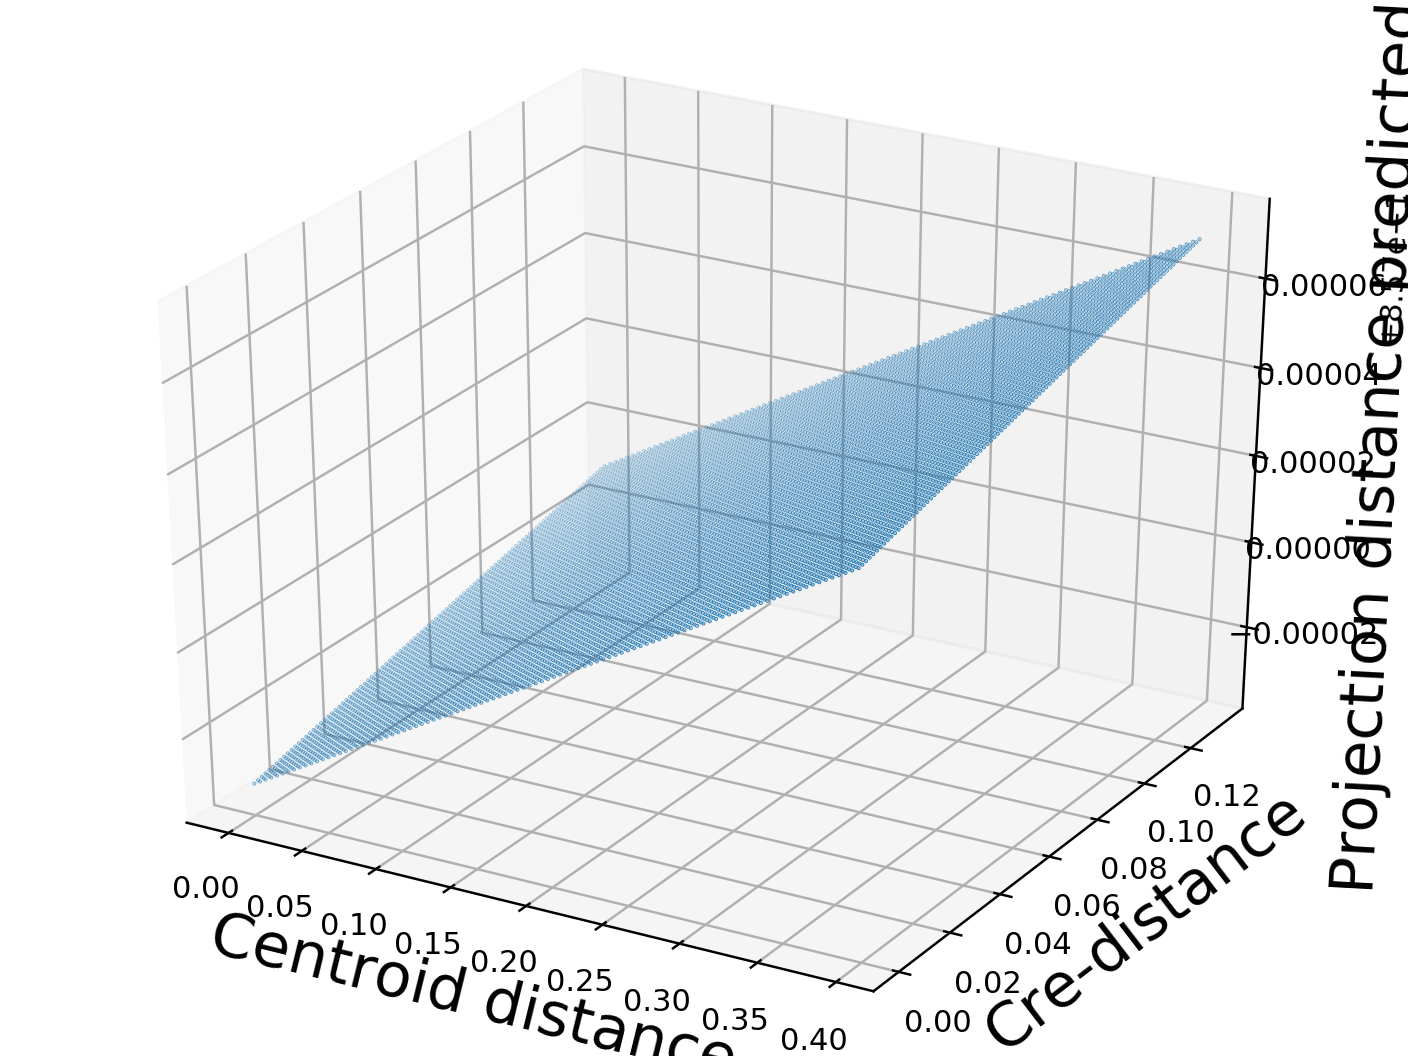

Text(0.5, 0, 'Projection distance predicted')

In [30]:
%matplotlib notebook
xs = np.linspace(0, dc[:,0].max(), 100)
ys = np.linspace(0, dc[:,1].max(), 100)
preds = np.empty((100,100))
for x in range(100):
    for y in range(100):
        preds[x,y] =qqq.predict(np.asarray([[xs[x], ys[y]]]))#asdf.predict(np.asarray([[xs[x], ys[y]]])) #qqq.predict(np.asarray([[xs[x], ys[y]]]))
        
        
        
mxy = np.asarray(np.meshgrid(xs,ys)).transpose()

#%matplotlib inline
fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(mxy[:,:,0], 
           mxy[:,:,1], 
           preds, s= .1)

#ax.set_axis_off()
ax.set_xlabel('Centroid distance', fontsize=20, rotation=150)
ax.set_ylabel('Cre-distance', fontsize=20, rotation=150)
ax.set_zlabel('Projection distance predicted', fontsize=20, rotation=150)

<IPython.core.display.Javascript object>


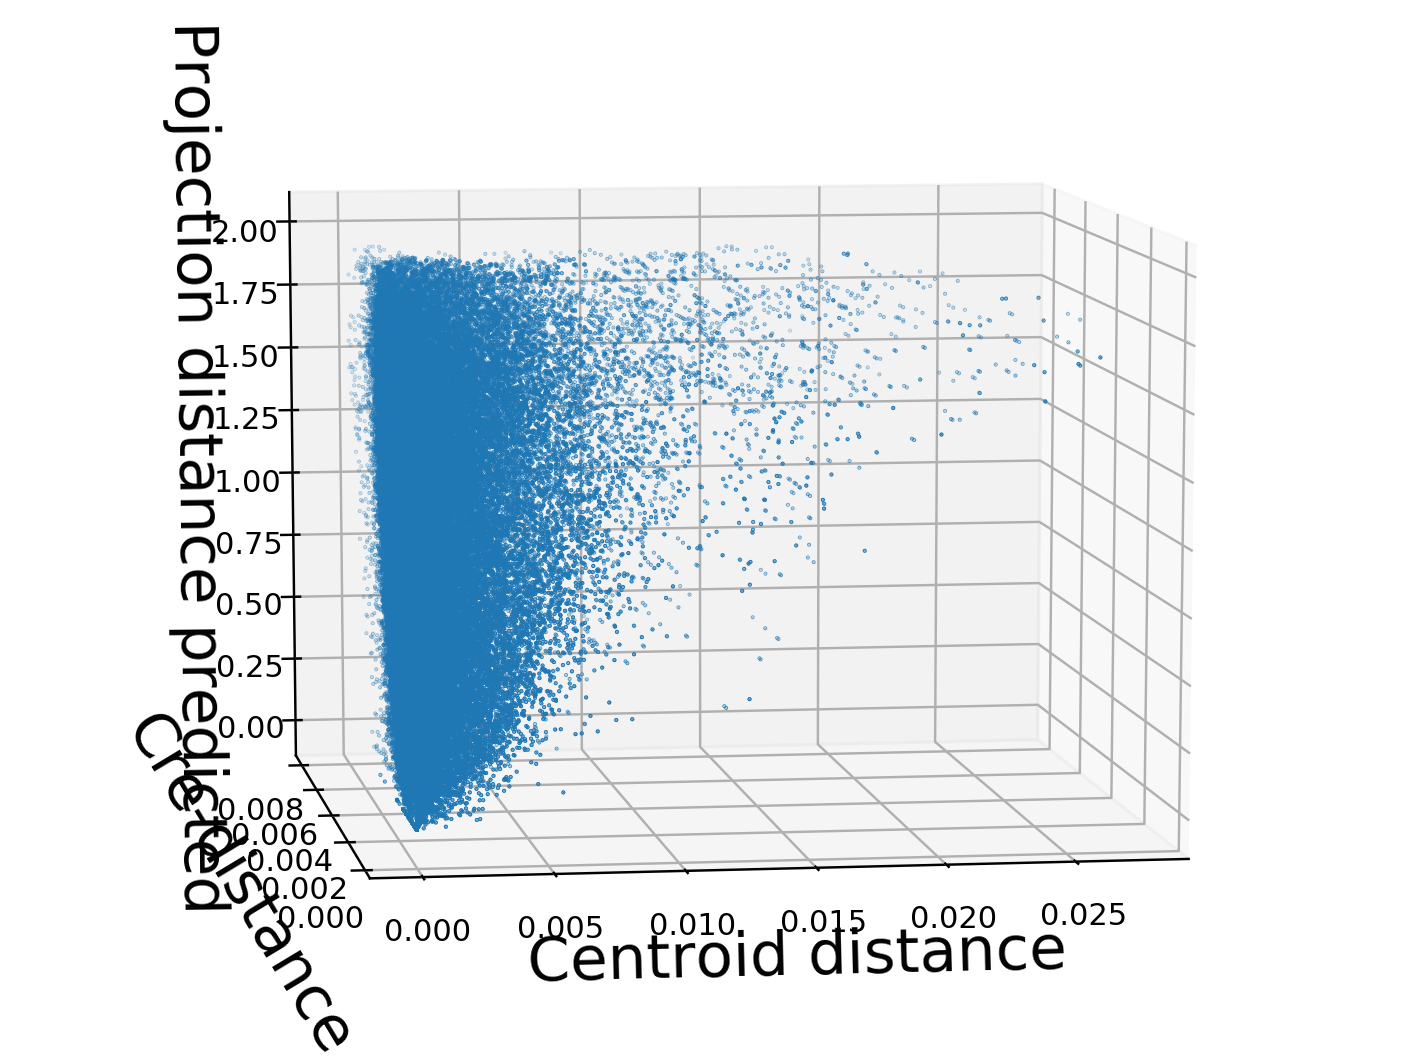

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/mpl_toolkits/mplot3d/art3d.py:794: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if zdir == 'x':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/mpl_toolkits/mplot3d/art3d.py:796: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif zdir == 'y':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/mpl_toolkits/mplot3d/art3d.py:798: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif zdir[0] == '-':


Text(0.5, 0, 'Projection distance predicted')

In [74]:
%matplotlib notebook

        
#mxy = np.asarray(np.meshgrid(xs,ys)).transpose()

#%matplotlib inline
fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(dc[:,0], 
           dc[:,1], dc[:,2],
           preds, s= .1)

#ax.set_axis_off()
ax.set_xlabel('Centroid distance', fontsize=20, rotation=150)
ax.set_ylabel('Cre-distance', fontsize=20, rotation=150)
ax.set_zlabel('Projection distance predicted', fontsize=20, rotation=150)

NadarayaWatson(coef0=1, degree=3, gamma=100, kernel='rbf', kernel_params=None)

<IPython.core.display.Javascript object>


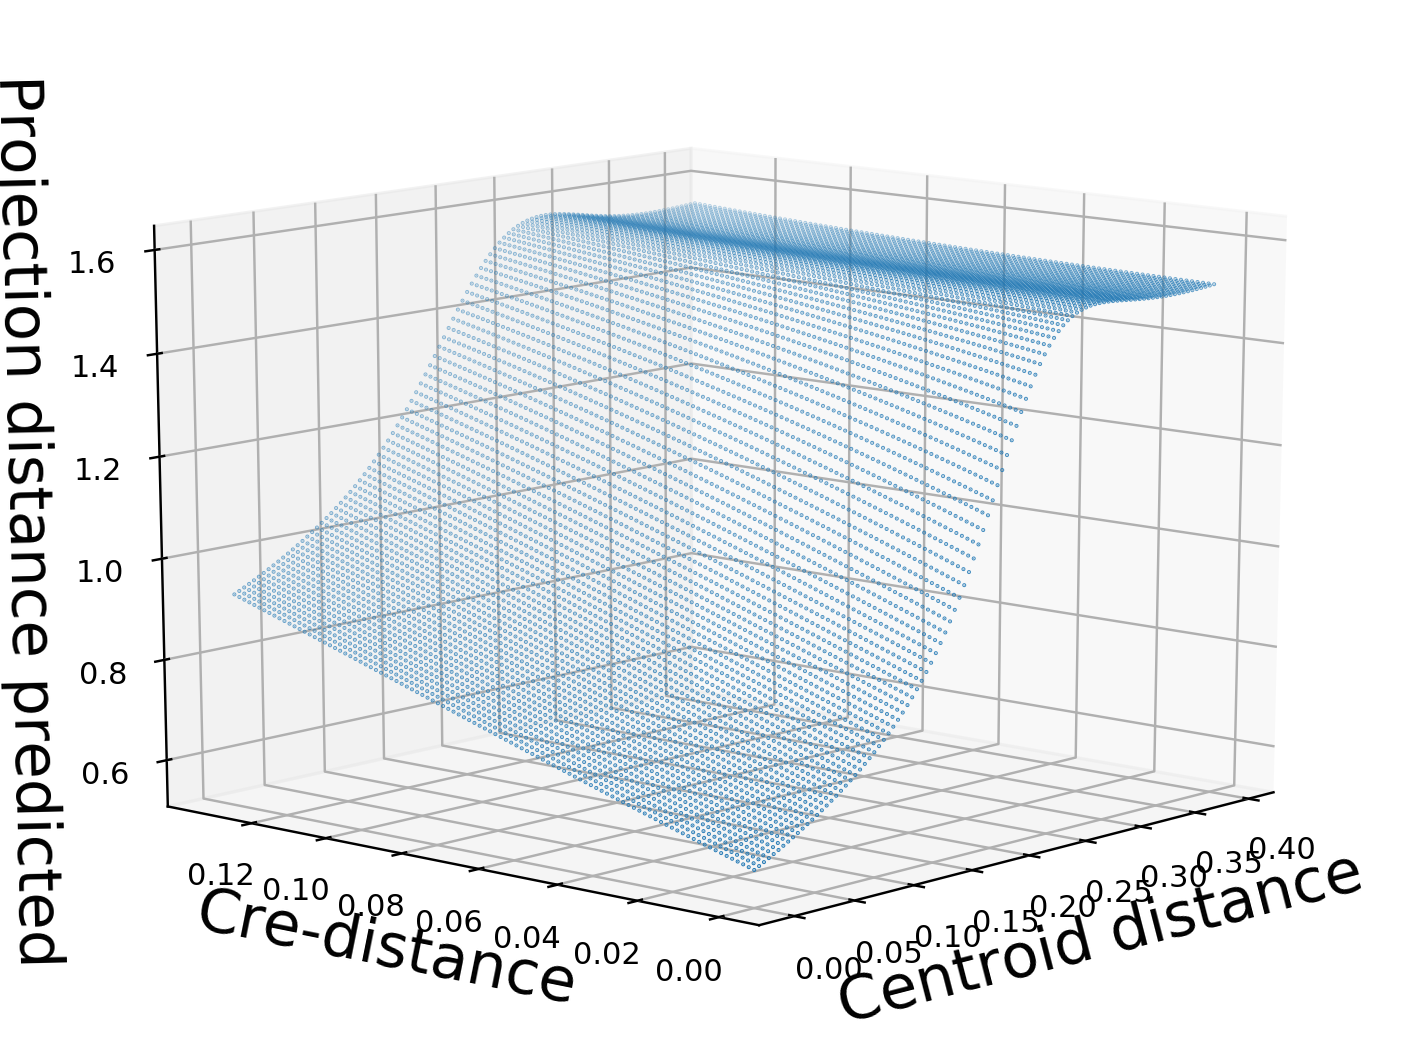

Text(0.5, 0, 'Projection distance predicted')

In [42]:
%matplotlib notebook

qqq = NadarayaWatson(kernel='rbf',  gamma  = 100)
#randos = random.sample(list(range(ngp)), math.floor(ngp * fraction))
qqq.fit(dc[:,:2], dc[:,2:])

xs = np.linspace(0, dc[:,0].max(), 100)
ys = np.linspace(0, dc[:,1].max(), 100)
preds = np.empty((100,100))
for x in range(100):
    for y in range(100):
        preds[x,y] =qqq.predict(np.asarray([[xs[x], ys[y]]]))#asdf.predict(np.asarray([[xs[x], ys[y]]])) #qqq.predict(np.asarray([[xs[x], ys[y]]]))
        
        
        
mxy = np.asarray(np.meshgrid(xs,ys)).transpose()

#%matplotlib inline
fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(mxy[:,:,0], 
           mxy[:,:,1], 
           preds, s= .1)

#ax.set_axis_off()
ax.set_xlabel('Centroid distance', fontsize=20, rotation=150)
ax.set_ylabel('Cre-distance', fontsize=20, rotation=150)
ax.set_zlabel('Projection distance predicted', fontsize=20, rotation=150)

In [50]:
def get_nwloocv_predictions_multimodel_merge_dists(projections, dists, gammas, model_index_matrix, eval_index_matrix):
    
    predictions_unmerged = get_nwloocv_predictions_multimodel_dists(projections, dists, gammas, model_index_matrix, eval_index_matrix)
    print(predictions_unmerged.shape)
    predictions_merged = combine_predictions(predictions_unmerged, eval_index_matrix)
    
    return(predictions_merged)
    
    
def get_nwloocv_predictions_multimodel_dists(projections, dists, gammas, model_index_matrix, eval_index_matrix):
    

    
    ntargets = projections.shape[1]
    nexp = projections.shape[0]
    nmodels = model_index_matrix.shape[0]
    ngammas = len(gammas)
    
    projections = np.asarray(projections, dtype=np.float32)
    predictions = np.empty((nmodels, ngammas, nexp, ntargets))
    
    
    for m in range(nmodels):
        #print('m', m, len(np.where(model_index_matrix[m] ==1)[0]))
        predictions[m] = np.asarray([get_nwloocv_predictions_singlemodel_dists(projections, dists, gammas[g], model_index_matrix[m], eval_index_matrix[m]) for g in range(ngammas)])
    
    return(predictions)  

def get_nwloocv_predictions_singlemodel_dists(projections, dists, gamma, model_indices, eval_indices):
  
    eval_index_val = np.where(eval_indices == 1)[0]
    model_index_val = np.where(model_indices == 1)[0]
    
    projections = np.asarray(projections, dtype=np.float32)
    
    nmod_ind = len(model_index_val)
    neval = len(eval_index_val)
    #nexp = centroids.shape[0]
    predictions = np.empty(projections.shape)
    #print(model_index_val.shape, eval_index_val.shape)

    if len(model_index_val) > 0 and  len(eval_index_val) > 0:
        weights = np.exp(-dists[model_index_val][:, eval_index_val] / gamma)#np.exp(-dists[model_index_val] / gamma) #get_weights(centroids, gamma)
        for i in range(neval):
            matchindex = np.where(model_index_val == eval_index_val[i])[0]
            otherindices = np.setdiff1d(np.asarray(list(range(nmod_ind))), matchindex)         
            #this order of operations is the fastest I found
            weights_i = weights[:,i] / weights[:,i][otherindices].sum()
            weights_i[matchindex] = 0
            weights_i = np.asarray(weights_i, dtype=np.float32)
            pred = np.dot(weights_i, projections[model_index_val])
            predictions[eval_index_val[i]] = pred

        
    return(predictions) 

In [51]:
gammas = np.asarray([0.1,.5,1,2,10])
for sid in major_structure_ids:
 
    
    msvds[sid].loocv_predictions_leaf_leaf2 = get_nwloocv_predictions_multimodel_merge_dists(msvds[sid].reg_proj_vcount_norm_renorm, 
                                                                                       sls[sid], 
                                                                                       gammas, 
                                                                                       indices_leaf2ormore[sid], 
                                                                                       indices_leaf2ormore[sid])
a= [list(range(5))]
keys = np.asarray(list(itertools.product(*a)))

reg_proj_vcount_norm_renorms= {}
nwloocv_leaf_leaf2 = {}
for sid in major_structure_ids:
    reg_proj_vcount_norm_renorms[sid ] = msvds[sid].reg_proj_vcount_norm_renorm
    nwloocv_leaf_leaf2[sid] = msvds[sid].loocv_predictions_leaf_leaf2

eval_indices_leaf2ormore = get_eval_indices(indices_leaf2ormore)

losses_leaf_leaf2 = get_loss(reg_proj_vcount_norm_renorms, nwloocv_leaf_leaf2,pred_ind = eval_indices_leaf2ormore, true_ind = eval_indices_leaf2ormore,keys = keys)
best_gamma_leaf_leaf2 = get_best_hyperparameters(losses_leaf_leaf2,keys)
meanloss_nw_leaf_leaf2 = get_loss_best_hyp(losses_leaf_leaf2, best_gamma_leaf_leaf2)

#meanloss_nw_leaf_leaf2wt
#meanloss_nw_wtleaf_leaf2wt

(13, 5, 36, 577)
(5, 5, 7, 577)
(18, 5, 122, 577)
(21, 5, 85, 577)
(119, 5, 1128, 577)
(23, 5, 68, 577)
(19, 5, 46, 577)
(9, 5, 35, 577)
(13, 5, 33, 577)
(7, 5, 30, 577)
(8, 5, 78, 577)
(29, 5, 83, 577)
0
1
2
3
4
5
6
7
8
9
10
11


In [52]:
output = pd.DataFrame(meanloss_nw_leaf_leaf2[[4,7,2,1,10,9,11,3,5,8,6,0]])

In [53]:
output.to_clipboard()

In [54]:
output

0
0   0.517239
1   0.467463
2   0.332592
3   0.444342
4   0.560552
5   0.310112
6   0.309806
7   0.250102
8   0.612333
9   0.328404
10  0.479289
11  0.877837

<IPython.core.display.Javascript object>


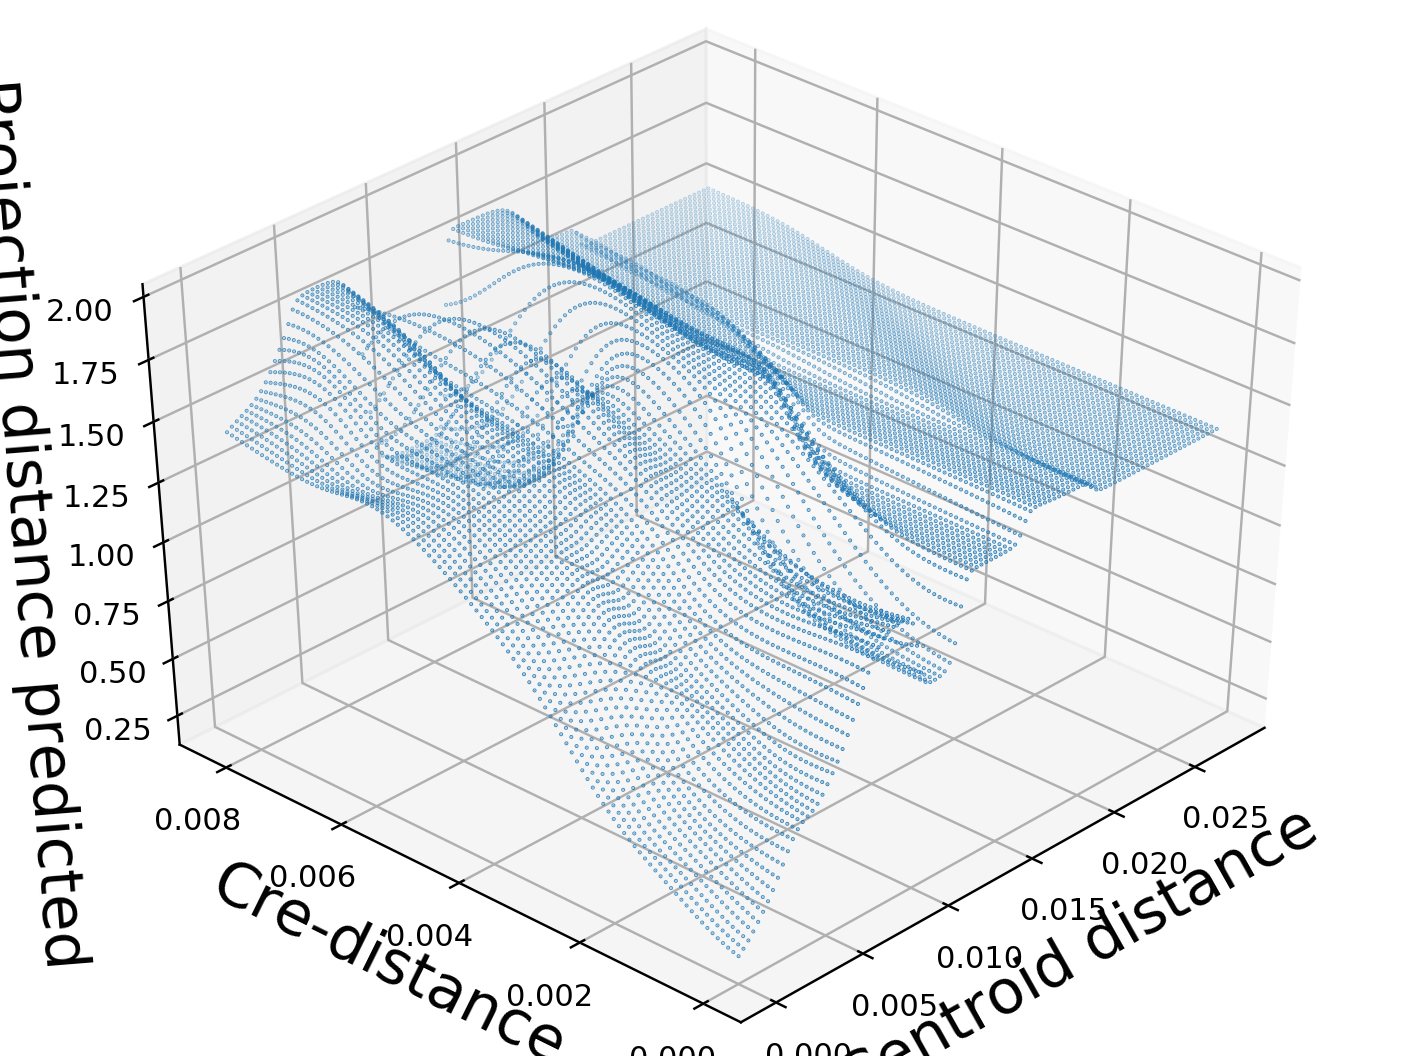

Text(0.5, 0, 'Projection distance predicted')

In [73]:
%matplotlib notebook

qqq = NadarayaWatson(kernel='rbf',  gamma  = 1000000)
ngp = dc.shape[0]
fraction = .01
randos = random.sample(list(range(ngp)), math.floor(ngp * fraction))
qqq.fit(dc[:,:2][randos], dc[:,2:][randos])

xs = np.linspace(0, dc[:,0].max(), 100)
ys = np.linspace(0, dc[:,1].max(), 100)
preds = np.empty((100,100))
for x in range(100):
    for y in range(100):
        preds[x,y] =qqq.predict(np.asarray([[xs[x], ys[y]]]))#asdf.predict(np.asarray([[xs[x], ys[y]]])) #qqq.predict(np.asarray([[xs[x], ys[y]]]))
        
        
        
mxy = np.asarray(np.meshgrid(xs,ys)).transpose()

#%matplotlib inline
fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(mxy[:,:,0], 
           mxy[:,:,1], 
           preds, s= .1)

#ax.set_axis_off()
ax.set_xlabel('Centroid distance', fontsize=20, rotation=150)
ax.set_ylabel('Cre-distance', fontsize=20, rotation=150)
ax.set_zlabel('Projection distance predicted', fontsize=20, rotation=150)

In [68]:
    sls[sid] = get_smoothed_losses(msvd,qqq, cre_dist2)

In [69]:
gammas = np.asarray([0.1,.5,1,2,10])
for sid in major_structure_ids[4:5]:
 
    
    msvds[sid].loocv_predictions_leaf_leaf2 = get_nwloocv_predictions_multimodel_merge_dists(msvds[sid].reg_proj_vcount_norm_renorm, 
                                                                                       sls[sid], 
                                                                                       gammas, 
                                                                                       indices_leaf2ormore[sid], 
                                                                                       indices_leaf2ormore[sid])
a= [list(range(5))]
keys = np.asarray(list(itertools.product(*a)))

reg_proj_vcount_norm_renorms= {}
nwloocv_leaf_leaf2 = {}
for sid in major_structure_ids[4:5]:
    reg_proj_vcount_norm_renorms[sid ] = msvds[sid].reg_proj_vcount_norm_renorm
    nwloocv_leaf_leaf2[sid] = msvds[sid].loocv_predictions_leaf_leaf2

eval_indices_leaf2ormore = get_eval_indices(indices_leaf2ormore)

losses_leaf_leaf2 = get_loss(reg_proj_vcount_norm_renorms, nwloocv_leaf_leaf2,pred_ind = eval_indices_leaf2ormore, true_ind = eval_indices_leaf2ormore,keys = keys)
best_gamma_leaf_leaf2 = get_best_hyperparameters(losses_leaf_leaf2,keys)
meanloss_nw_leaf_leaf2 = get_loss_best_hyp(losses_leaf_leaf2, best_gamma_leaf_leaf2)

#meanloss_nw_leaf_leaf2wt
#meanloss_nw_wtleaf_leaf2wt

(119, 5, 1128, 577)
0


In [70]:
meanloss_nw_leaf_leaf2

array([0.29608626])

In [71]:
output.to_clipboard()